# **Implementation of Multi Layer Perceptron Algorithm from scratch**

In [1]:
import torch
print(torch.__version__)
import torch.nn as nn
import numpy as np

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

2.8.0+cu126


In [2]:
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),               # Converts to float tensor [0,1] and adds channel dimension
    transforms.Lambda(lambda x: x.view(-1))  # Flatten tensor of dimension 28x28 to vector of size 784
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [3]:
print(f"The number of images in training dataset are {len(mnist_trainset)}")
print(f"The number of images in test dataset are {len(mnist_testset)}")

print(mnist_trainset.data.shape)
print(mnist_testset.data.shape)

The number of images in training dataset are 60000
The number of images in test dataset are 10000
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [4]:
print(mnist_trainset[0][0].shape)

torch.Size([784])


In [5]:
batch_size = 64
train_loader = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=batch_size, shuffle=False)

#**Question 1 Part A:**
#Implementing Multi Layer Perceptron using Sigmoid Activation function

Model architecture:
- Input layer (784 neurons)
- Hidden layers with 500, 250, and 100 neurons using Sigmoid activations
- Output layer with 10 neurons (linear, raw logits)
- Use of softmax for probability assignment
- Glorot uniform weight initialization and zeros biases per assignment

In [6]:
class MLP(nn.Module):
  def __init__(self, input_dim = 784, hidden_dims = [500, 250, 100], output_dim = 10 ):

      layer_sizes = [input_dim] + hidden_dims + [output_dim]

      # Initialize weights and biases (Glorot initialization, zero biases)
      self.weights = []
      self.biases = []
      for i in range(len(layer_sizes) - 1):
          ip_layer_size = layer_sizes[i]
          op_layer_size = layer_sizes[i + 1]
          limit = np.sqrt(6 / (ip_layer_size + op_layer_size))
          W = np.random.uniform(-limit, limit, size=(ip_layer_size, op_layer_size))
          b = np.zeros((1, op_layer_size))
          self.weights.append(W)
          self.biases.append(b)

  def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

  def sigmoid_derivative(self, x):
        return x * (1 - x)

  def softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / exp_x.sum(axis=1, keepdims=True)

  def forward(self, X):
        # Storing the inputs in arrays for backpropogation
        self.inputs = []
        self.z_values = []

        # Input layer to first hidden layer
        z1 = X @ self.weights[0] + self.biases[0]
        a1 = self.sigmoid(z1)

        # First hidden layer to second hidden layer
        z2 = a1 @ self.weights[1] + self.biases[1]
        a2 = self.sigmoid(z2)

        # Second hidden layer to third one
        z3 = a2 @ self.weights[2] + self.biases[2]
        a3 = self.sigmoid(z3)

        # Third hidden layer to raw output
        z4 = a3 @ self.weights[3] + self.biases[3]

        # Outut layer
        output = self.softmax(z4)

        self.inputs = [X, a1, a2, a3]
        self.z_values = [z1, z2, z3, z4]

        return output

  def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]  #number of samples in the batch
        eps = 1e-9  #value to avoid log(0)
        log_preds = np.log(y_pred + eps)  #log of prediction
        loss = -np.sum(y_true * log_preds) / m
        return loss

  def backward(self, y_true, y_pred, learning_rate):
        m = y_true.shape[0]

        delta4 = (y_pred - y_true) / m  # output error

        dW4 = self.inputs[3].T @ delta4
        db4 = np.sum(delta4, axis=0, keepdims=True)

        delta3 = delta4 @ self.weights[3].T * self.sigmoid_derivative(self.inputs[3])
        dW3 = self.inputs[2].T @ delta3
        db3 = np.sum(delta3, axis=0, keepdims=True)

        delta2 = delta3 @ self.weights[2].T * self.sigmoid_derivative(self.inputs[2])
        dW2 = self.inputs[1].T @ delta2
        db2 = np.sum(delta2, axis=0, keepdims=True)

        delta1 = delta2 @ self.weights[1].T * self.sigmoid_derivative(self.inputs[1])
        dW1 = self.inputs[0].T @ delta1
        db1 = np.sum(delta1, axis=0, keepdims=True)

        # Update weights and biases
        self.weights[3] -= learning_rate * dW4
        self.biases[3] -= learning_rate * db4

        self.weights[2] -= learning_rate * dW3
        self.biases[2] -= learning_rate * db3

        self.weights[1] -= learning_rate * dW2
        self.biases[1] -= learning_rate * db2

        self.weights[0] -= learning_rate * dW1
        self.biases[0] -= learning_rate * db1


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

In [9]:
def train(model, train_loader, epochs=15, learning_rate=0.01, log_interval=200):
    loss_history = []     # epoch losses
    iter_losses = []      # losses every 200 updates
    iters = []            # iteration numbers

    iteration = 0

    for epoch in range(epochs):
        epoch_loss = 0.0
        batch_count = 0

        for images, labels in train_loader:
            iteration += 1
            X = images.numpy()
            y_indices = labels.numpy()
            y = one_hot_encode(y_indices)

            output = model.forward(X)
            loss = model.compute_loss(y, output)

            epoch_loss += float(loss)
            batch_count += 1
            model.backward(y, output, learning_rate)

            # log every 200 updates
            if iteration % log_interval == 0:
                avg_loss_so_far = epoch_loss / batch_count
                iter_losses.append(avg_loss_so_far)
                iters.append(iteration)

        avg_loss = epoch_loss / batch_count
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

        # plot epoch curve so far
        plt.figure(figsize=(6,4))
        plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
        plt.title("Training Loss per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()

    # plot iteration-based curve once at the end
    plt.figure(figsize=(6,4))
    plt.plot(iters, iter_losses, marker='o')
    plt.title(f"Training Loss (every {log_interval} updates)")
    plt.xlabel("Iterations (batch updates)")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

    return loss_history, iters, iter_losses

In [10]:
from sklearn.metrics import confusion_matrix, classification_report

In [11]:
def predict(model, X):
    probs = model.forward(X)
    preds = np.argmax(probs, axis=1)
    return preds

def evaluate(model, X, y_true):
    preds = predict(model, X)
    accuracy = np.mean(preds == y_true)
    print(f"Accuracy: {accuracy*100:.4f}%")

    print("Confusion Matrix:")
    print(confusion_matrix(y_true, preds))

    print("\nClassification Report:")
    print(classification_report(y_true, preds))

    return accuracy

def plot_training_curves(train_losses):
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
    plt.title("Training Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()


Epoch 1/15, Loss: 2.3007


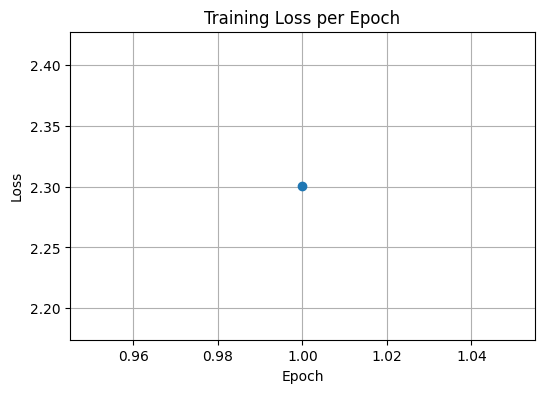

Epoch 2/15, Loss: 2.2873


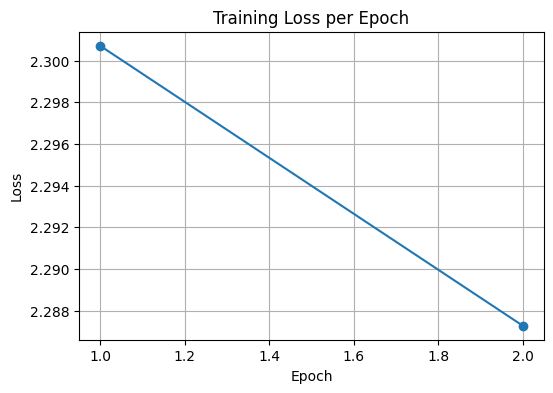

Epoch 3/15, Loss: 2.2729


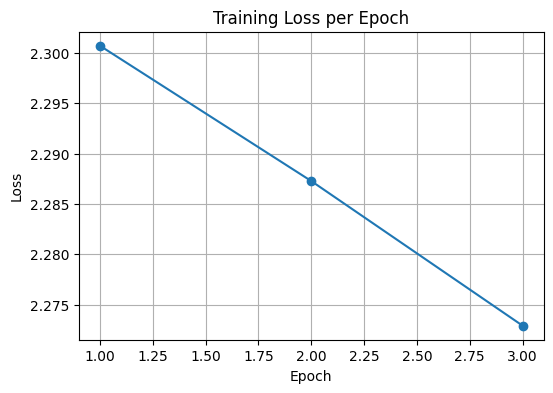

Epoch 4/15, Loss: 2.2526


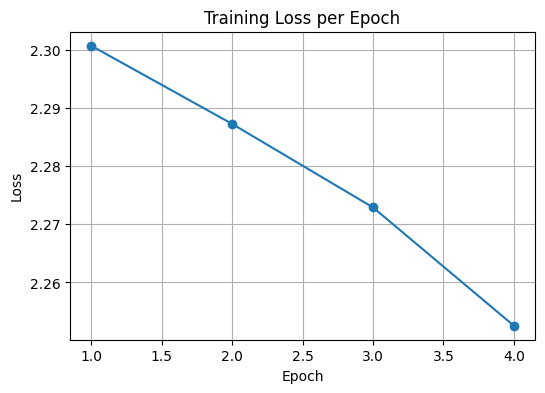

Epoch 5/15, Loss: 2.2186


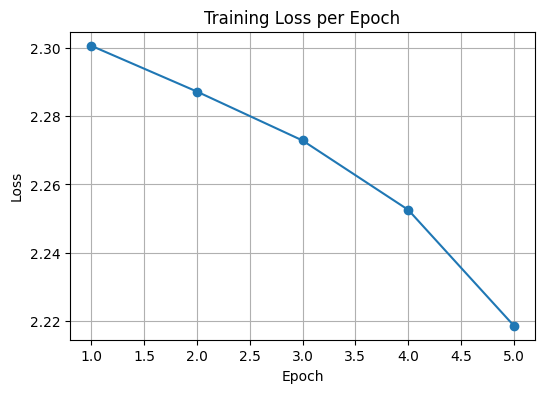

Epoch 6/15, Loss: 2.1535


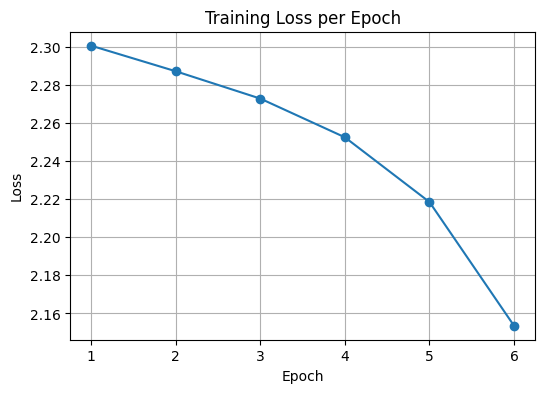

Epoch 7/15, Loss: 2.0126


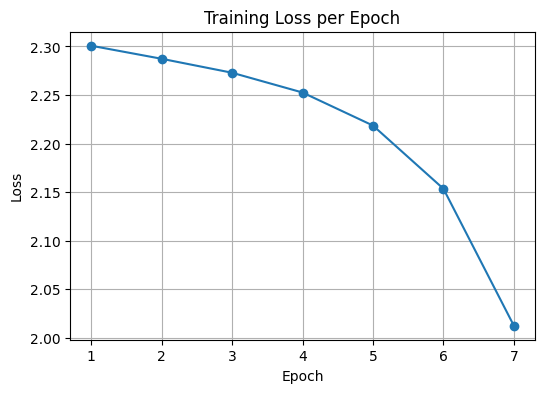

Epoch 8/15, Loss: 1.7371


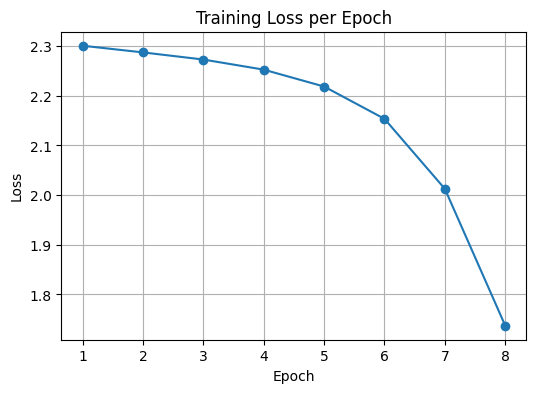

Epoch 9/15, Loss: 1.4044


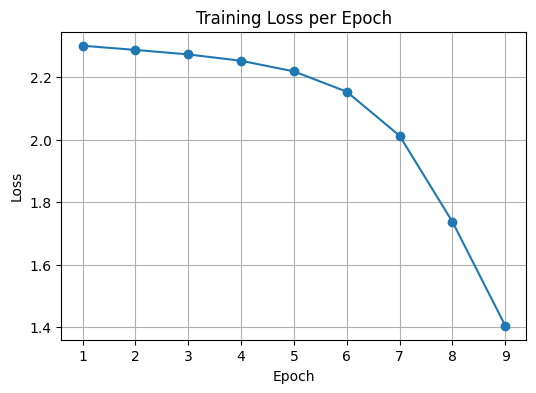

Epoch 10/15, Loss: 1.1582


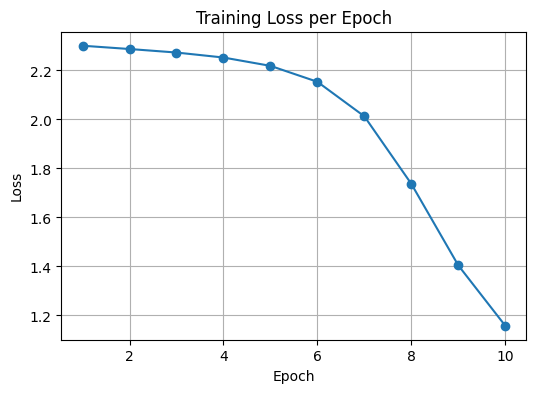

Epoch 11/15, Loss: 1.0025


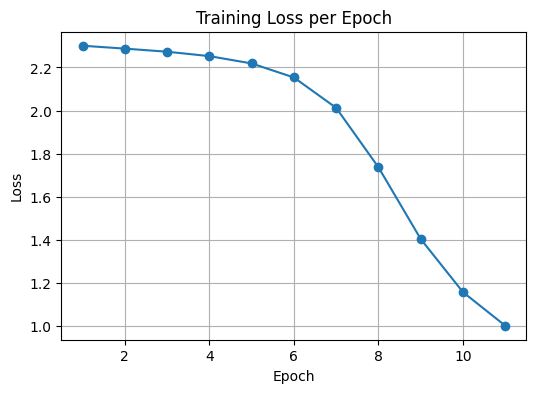

Epoch 12/15, Loss: 0.8956


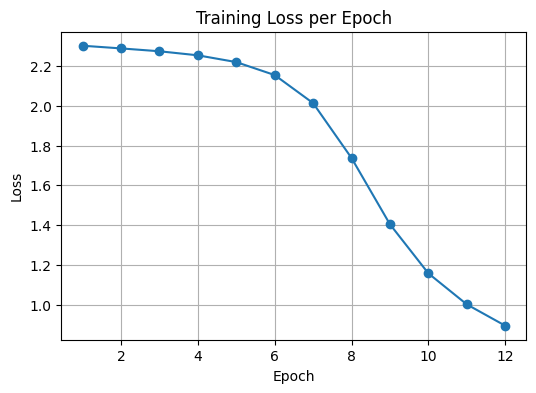

Epoch 13/15, Loss: 0.8119


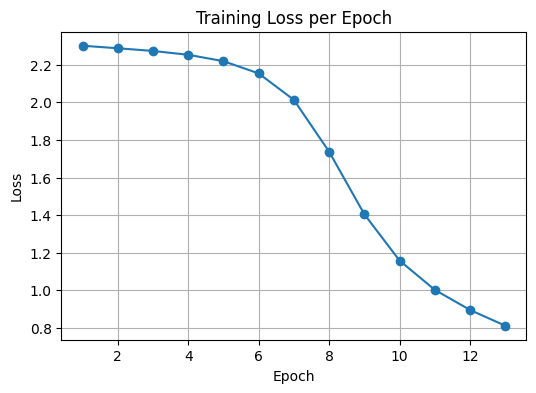

Epoch 14/15, Loss: 0.7401


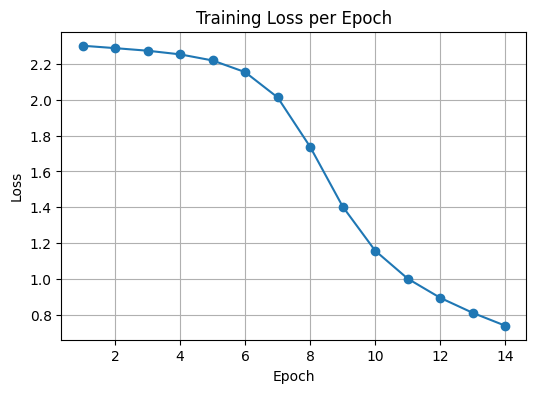

Epoch 15/15, Loss: 0.6783


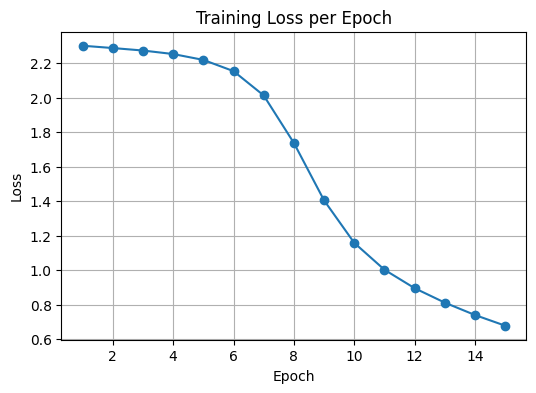

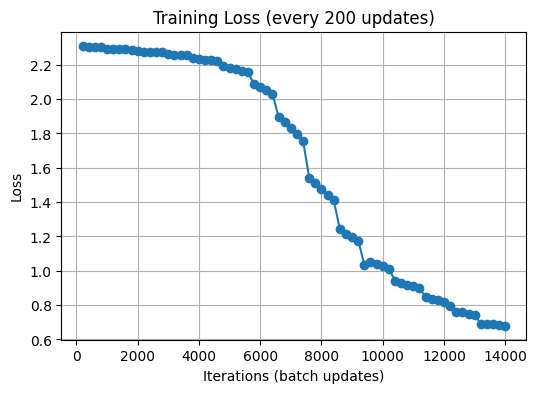

In [12]:
model = MLP()
loss_history, iter_num, iter_loss = train(model, train_loader, 15, 0.01)


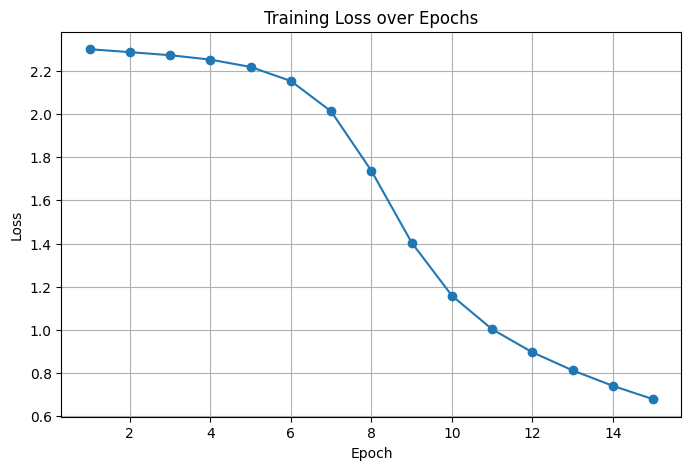

In [13]:
plot_training_curves(loss_history)

In [14]:
# Prepare test set in numpy format
X_test_np = mnist_testset.data.numpy().reshape(-1, 28*28) / 255.0
y_test_np = mnist_testset.targets.numpy()

print("---- Test Set Evaluation ----")
evaluate(model, X_test_np, y_test_np)


---- Test Set Evaluation ----
Accuracy: 82.3200%
Confusion Matrix:
[[ 944    0    2    1    3   19    9    1    1    0]
 [   0 1114    3    3    0    0    3    1   10    1]
 [  15   28  840   25   27    8   52   12   25    0]
 [   5    7   47  810    2   64    0   21   50    4]
 [   2   12    1    0  832    0   30    1    5   99]
 [  27    6   24   92   35  593   32   11   41   31]
 [  29    4   15    0   11   18  879    0    2    0]
 [   6   45   12    2   12    1    0  916    7   27]
 [  12   29   37   66   25   86   21   13  651   34]
 [  14    7    2    8  207   17    3   94    4  653]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       980
           1       0.89      0.98      0.93      1135
           2       0.85      0.81      0.83      1032
           3       0.80      0.80      0.80      1010
           4       0.72      0.85      0.78       982
           5       0.74      0.66      0.70       892

np.float64(0.8232)

# **Results for MLP using Sigmoid activation function**

* Classfication accuracy over test data  = **82.30%**
* Training loss after 15 epochs = **0.6783**

#**Question 1 Part B**

#Implementing Multi Layer Perceptron Algorithm using ReLu activation function

Model architecture:

* Input layer (784 neurons)
* Hidden layers with 500, 250, and 100 neurons using ReLu as activation function
* Output layer with 10 neurons (linear, raw logits)
* Use of softmax for probability assignment
* Glorot uniform weight initialization and zeros biases per assignment

In [15]:
class MLP_ReLu(nn.Module):
    def __init__(self, input_dim=784, hidden_dims=[500, 250, 100], output_dim=10 ):

        layer_sizes = [input_dim] + hidden_dims + [output_dim]

        # Initialize weights and biases (Glorot initialization, zero biases)
        self.weights = []
        self.biases = []
        for i in range(len(layer_sizes) - 1):
            ip__layer_size = layer_sizes[i]
            op__layer_size = layer_sizes[i + 1]
            limit = np.sqrt(6 / (ip__layer_size + op__layer_size))
            W = np.random.uniform(-limit, limit, size=(ip__layer_size, op__layer_size))
            b = np.zeros((1, op__layer_size))
            self.weights.append(W)
            self.biases.append(b)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / exp_x.sum(axis=1, keepdims=True)

    def forward(self, X):
        self.inputs = []
        self.z_values = []

        # Input layer to first hidden layer
        z1 = X @ self.weights[0] + self.biases[0]
        a1 = self.relu(z1)

        # First hidden layer to second hidden layer
        z2 = a1 @ self.weights[1] + self.biases[1]
        a2 = self.relu(z2)

        # Second hidden layer to third one
        z3 = a2 @ self.weights[2] + self.biases[2]
        a3 = self.relu(z3)

        # Third hidden layer to output using Softmax
        z4 = a3 @ self.weights[3] + self.biases[3]
        output = self.softmax(z4)

        self.inputs = [X, a1, a2, a3]
        self.z_values = [z1, z2, z3, z4]
        return output

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]  #number of samples in the batch
        eps = 1e-9  #value to avoid log(0)
        log_preds = np.log(y_pred + eps)  #log of prediction
        loss = -np.sum(y_true * log_preds) / m
        return loss

    def backward(self, y_true, y_pred, learning_rate):
        m = y_true.shape[0]
        delta4 = (y_pred - y_true) / m

        dW4 = self.inputs[3].T @ delta4
        db4 = np.sum(delta4, axis=0, keepdims=True)

        delta3 = delta4 @ self.weights[3].T * self.relu_derivative(self.inputs[3])
        dW3 = self.inputs[2].T @ delta3
        db3 = np.sum(delta3, axis=0, keepdims=True)

        delta2 = delta3 @ self.weights[2].T * self.relu_derivative(self.inputs[2])
        dW2 = self.inputs[1].T @ delta2
        db2 = np.sum(delta2, axis=0, keepdims=True)

        delta1 = delta2 @ self.weights[1].T * self.relu_derivative(self.inputs[1])
        dW1 = self.inputs[0].T @ delta1
        db1 = np.sum(delta1, axis=0, keepdims=True)

        # Update weights and biases
        self.weights[3] -= learning_rate * dW4
        self.biases[3] -= learning_rate * db4

        self.weights[2] -= learning_rate * dW3
        self.biases[2] -= learning_rate * db3

        self.weights[1] -= learning_rate * dW2
        self.biases[1] -= learning_rate * db2

        self.weights[0] -= learning_rate * dW1
        self.biases[0] -= learning_rate * db1


Epoch 1/15, Loss: 0.7448


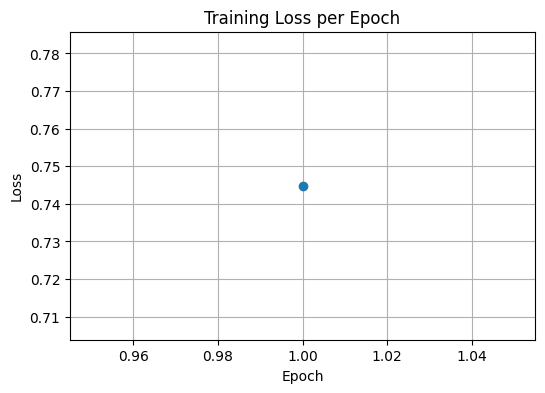

Epoch 2/15, Loss: 0.3028


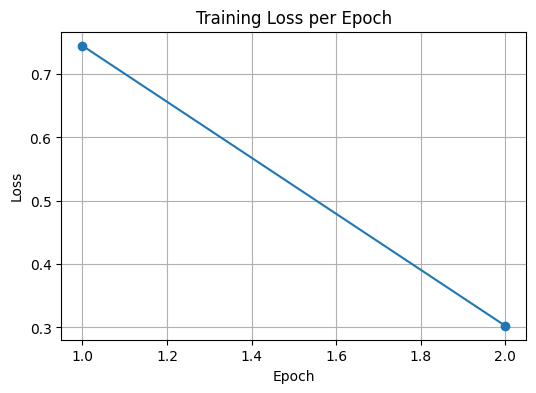

Epoch 3/15, Loss: 0.2479


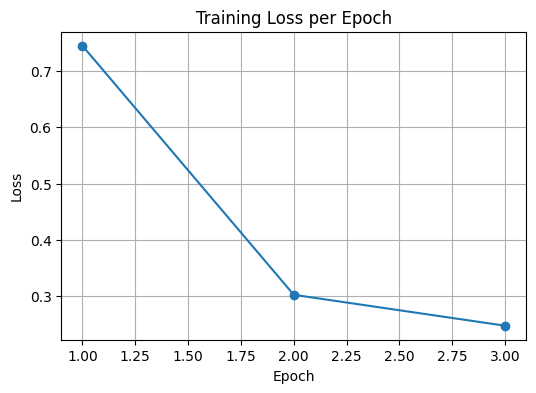

Epoch 4/15, Loss: 0.2138


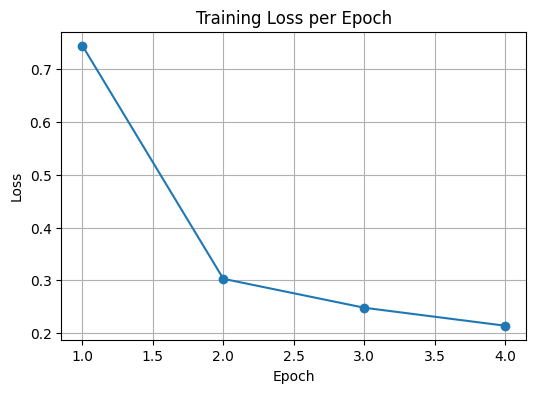

Epoch 5/15, Loss: 0.1874


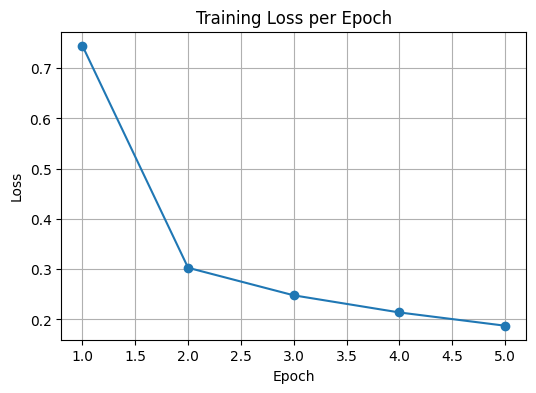

Epoch 6/15, Loss: 0.1668


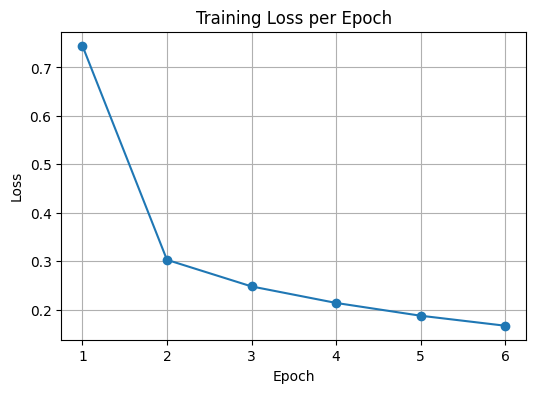

Epoch 7/15, Loss: 0.1496


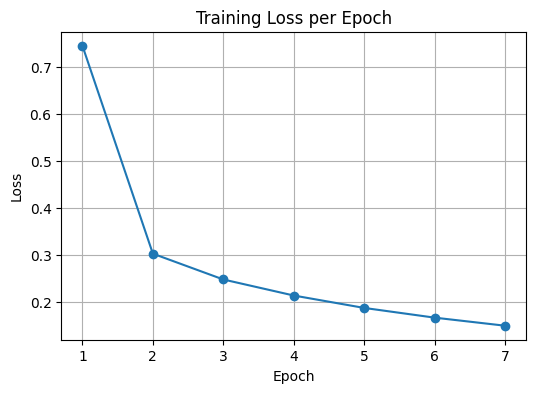

Epoch 8/15, Loss: 0.1353


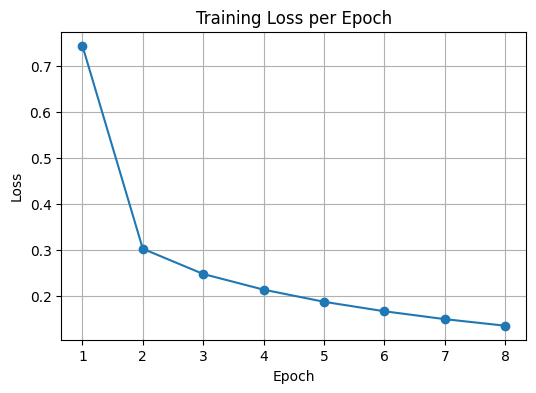

Epoch 9/15, Loss: 0.1231


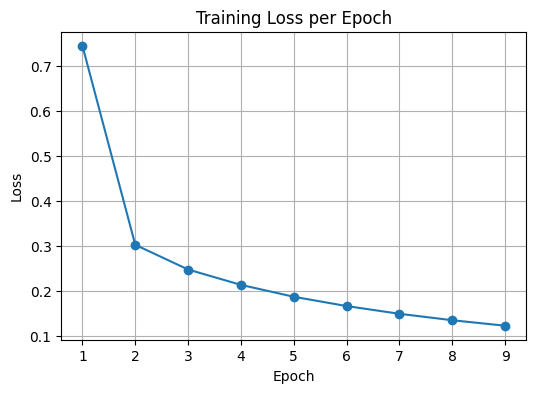

Epoch 10/15, Loss: 0.1127


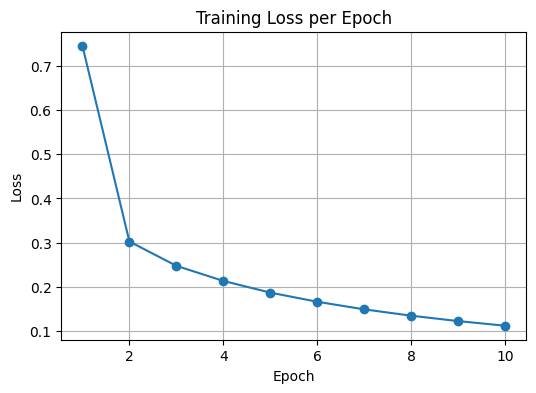

Epoch 11/15, Loss: 0.1033


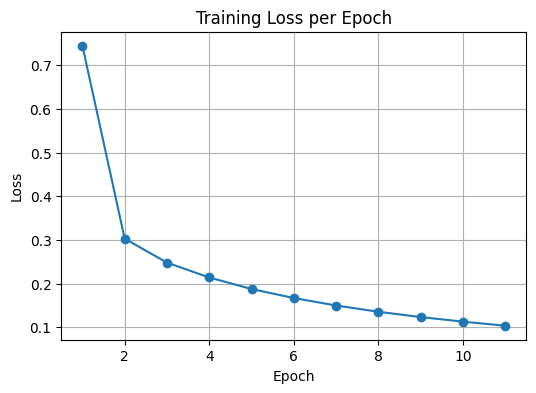

Epoch 12/15, Loss: 0.0952


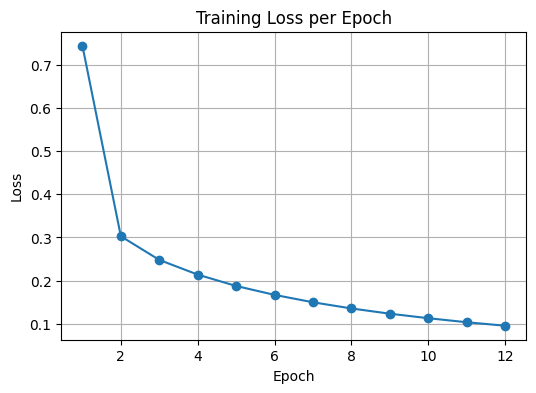

Epoch 13/15, Loss: 0.0878


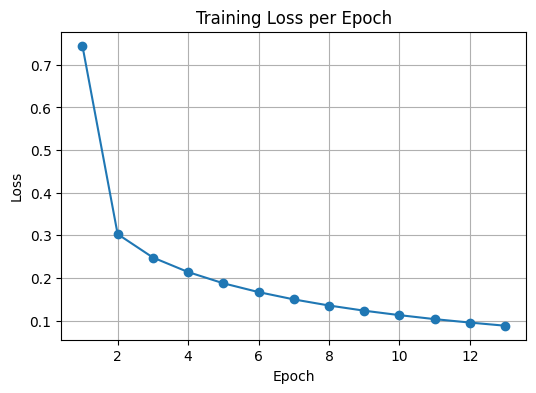

Epoch 14/15, Loss: 0.0812


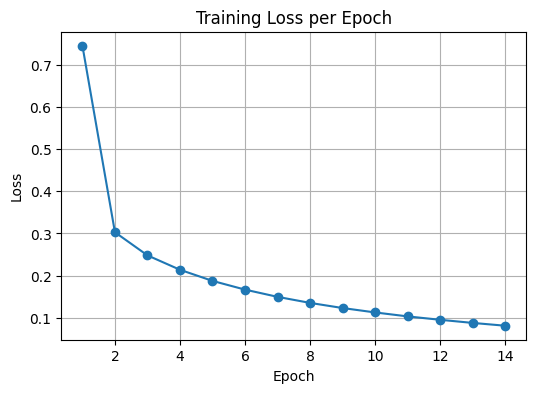

Epoch 15/15, Loss: 0.0753


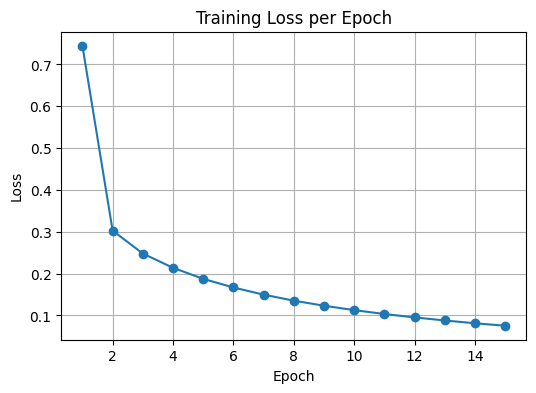

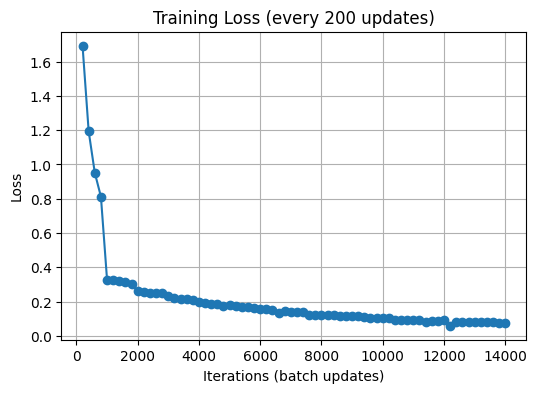

In [16]:
model = MLP_ReLu()
loss_history_ReLu, iter_ReLu, iter_loss_ReLu = train(model, train_loader)

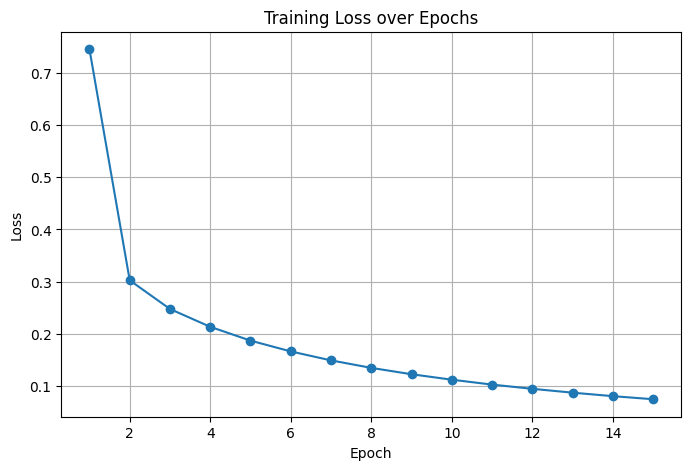

In [17]:
plot_training_curves(loss_history_ReLu)

In [18]:
# Prepare test set in numpy format
X_test_np = mnist_testset.data.numpy().reshape(-1, 28*28) / 255.0
y_test_np = mnist_testset.targets.numpy()

print("---- Test Set Evaluation ----")
evaluate(model, X_test_np, y_test_np)

---- Test Set Evaluation ----
Accuracy: 97.1200%
Confusion Matrix:
[[ 963    0    1    1    0    5    4    2    2    2]
 [   0 1126    4    0    0    1    4    0    0    0]
 [   4    3 1003    4    4    0    2    6    6    0]
 [   0    0    4  983    0    8    0    7    5    3]
 [   2    0    4    1  957    0    3    2    2   11]
 [   4    0    0    6    2  866    9    0    3    2]
 [   6    3    0    0    6   10  931    0    2    0]
 [   1    9   10    4    2    1    0  990    2    9]
 [   3    0    3    9    3    6    7    6  933    4]
 [   4    5    1    8   17    3    1    7    3  960]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.96      0.97      0.97       892

np.float64(0.9712)

# **Results for MLP using ReLU activation function**

* Classfication accuracy over test data  = **97.12%**
* Training loss after 15 epochs = **0.0753**

#**Question 1 Part C**

#Implementing Multi Layer Perceptron Algorithm using Tan Hyperbolic activation function

Model architecture:




* Input layer (784 neurons)
* Hidden layers with 500, 250, and 100 neurons using Tanh as activation
* Output layer with 10 neurons (linear, raw logits)
* Use of softmax for probability assignment
* Glorot uniform weight initialization and zeros biases per assignment



In [19]:
class MLP_tanh:
    def __init__(self, input_dim = 784, hidden_dims = [500, 250, 100], output_dim = 10 ):

      layer_sizes = [input_dim] + hidden_dims + [output_dim]

      # Initialize weights and biases (Glorot initialization, zero biases)
      self.weights = []
      self.biases = []
      for i in range(len(layer_sizes) - 1):
          ip__layer_size = layer_sizes[i]
          op__layer_size = layer_sizes[i + 1]
          limit = np.sqrt(6 / (ip__layer_size + op__layer_size))
          W = np.random.uniform(-limit, limit, size=(ip__layer_size, op__layer_size))
          b = np.zeros((1, op__layer_size))
          self.weights.append(W)
          self.biases.append(b)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1.0 - np.tanh(x)**2

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / exp_x.sum(axis=1, keepdims=True)

    def forward(self, X):
        self.inputs = []
        self.z_values = []

        # Input layer to first hidden layer
        z1 = X @ self.weights[0] + self.biases[0]
        a1 = self.tanh(z1)

        # First hidden layer to second hidden layer
        z2 = a1 @ self.weights[1] + self.biases[1]
        a2 = self.tanh(z2)

        # Second hidden layer to third one
        z3 = a2 @ self.weights[2] + self.biases[2]
        a3 = self.tanh(z3)

        # Third hidden layer to output using Softmax
        z4 = a3 @ self.weights[3] + self.biases[3]
        output = self.softmax(z4)

        self.inputs = [X, a1, a2, a3]
        self.z_values = [z1, z2, z3, z4]
        return output

    def compute_loss(self, y_true, y_pred):
      m = y_true.shape[0]  #number of samples in the batch
      eps = 1e-9  #value to avoid log(0)
      log_preds = np.log(y_pred + eps)  #log of prediction
      loss = -np.sum(y_true * log_preds) / m
      return loss

    def backward(self, y_true, y_pred, learning_rate):
        m = y_true.shape[0]
        delta4 = (y_pred - y_true) / m

        dW4 = self.inputs[3].T @ delta4
        db4 = np.sum(delta4, axis=0, keepdims=True)

        delta3 = delta4 @ self.weights[3].T * self.tanh_derivative(self.inputs[3])
        dW3 = self.inputs[2].T @ delta3
        db3 = np.sum(delta3, axis=0, keepdims=True)

        delta2 = delta3 @ self.weights[2].T * self.tanh_derivative(self.inputs[2])
        dW2 = self.inputs[1].T @ delta2
        db2 = np.sum(delta2, axis=0, keepdims=True)

        delta1 = delta2 @ self.weights[1].T * self.tanh_derivative(self.inputs[1])
        dW1 = self.inputs[0].T @ delta1
        db1 = np.sum(delta1, axis=0, keepdims=True)

        # Update weights and biases
        self.weights[3] -= learning_rate * dW4
        self.biases[3] -= learning_rate * db4

        self.weights[2] -= learning_rate * dW3
        self.biases[2] -= learning_rate * db3

        self.weights[1] -= learning_rate * dW2
        self.biases[1] -= learning_rate * db2

        self.weights[0] -= learning_rate * dW1
        self.biases[0] -= learning_rate * db1


Epoch 1/15, Loss: 0.5867


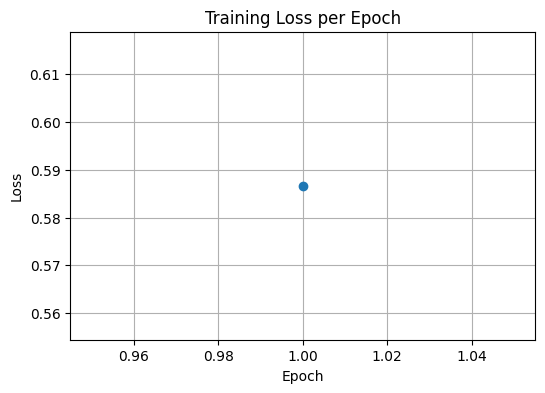

Epoch 2/15, Loss: 0.3330


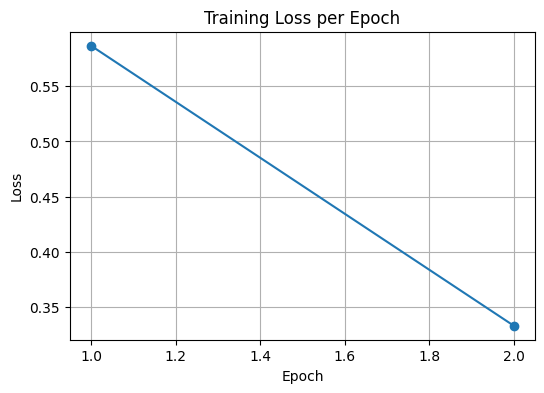

Epoch 3/15, Loss: 0.2909


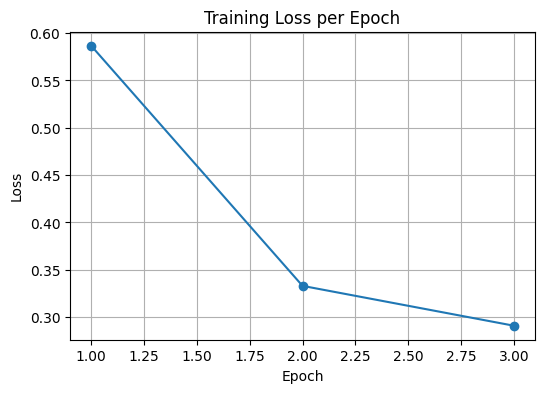

Epoch 4/15, Loss: 0.2665


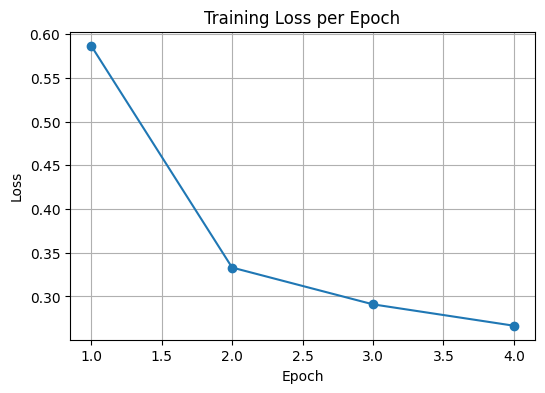

Epoch 5/15, Loss: 0.2488


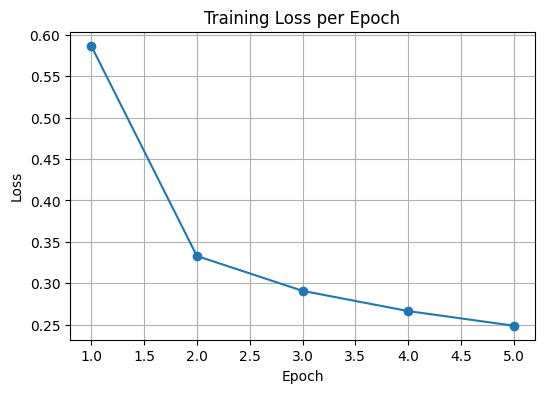

Epoch 6/15, Loss: 0.2339


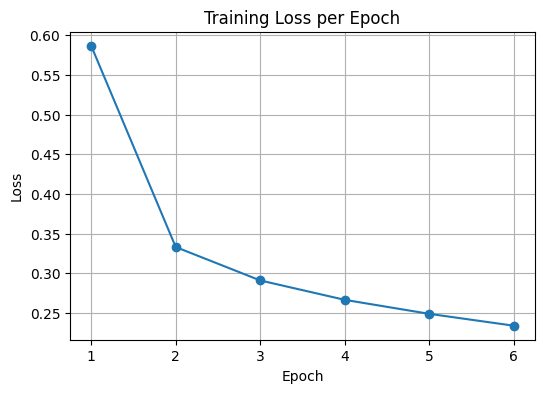

Epoch 7/15, Loss: 0.2209


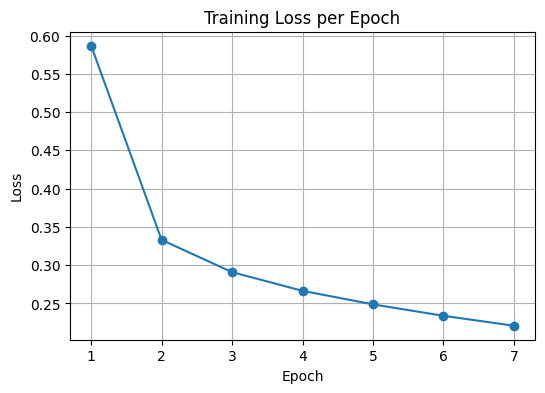

Epoch 8/15, Loss: 0.2095


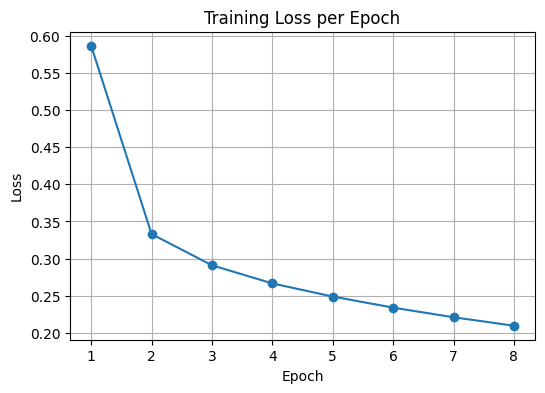

Epoch 9/15, Loss: 0.1989


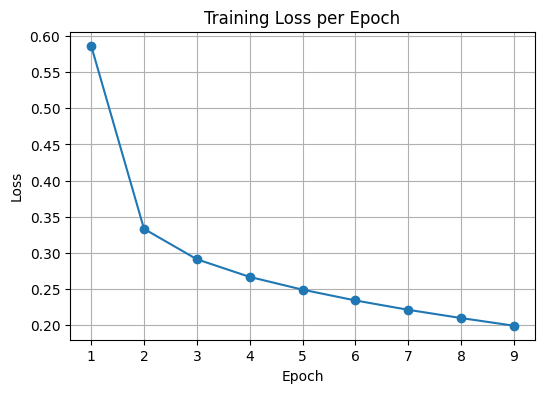

Epoch 10/15, Loss: 0.1891


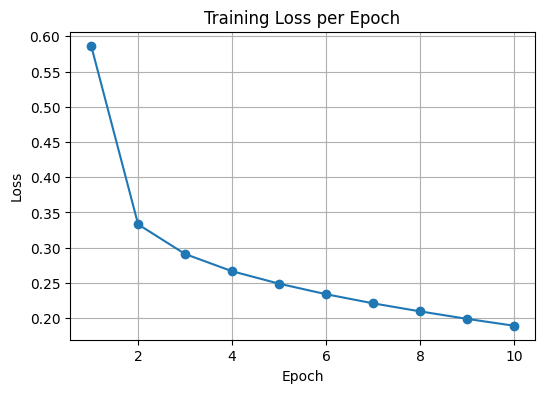

Epoch 11/15, Loss: 0.1801


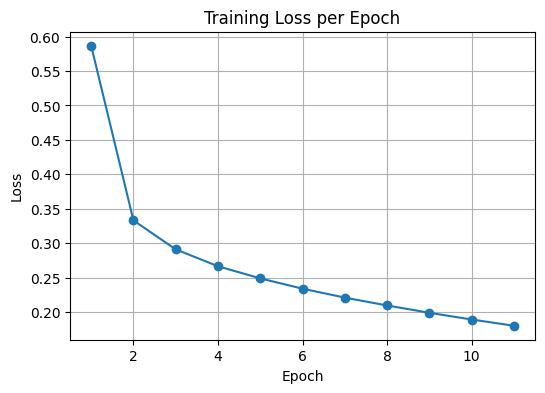

Epoch 12/15, Loss: 0.1718


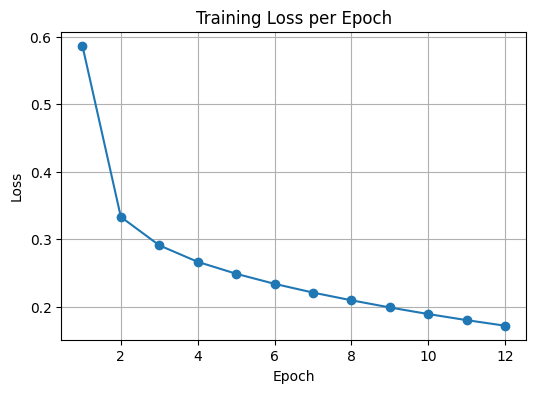

Epoch 13/15, Loss: 0.1642


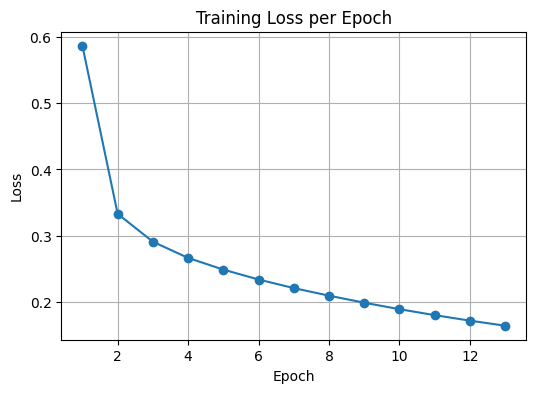

Epoch 14/15, Loss: 0.1570


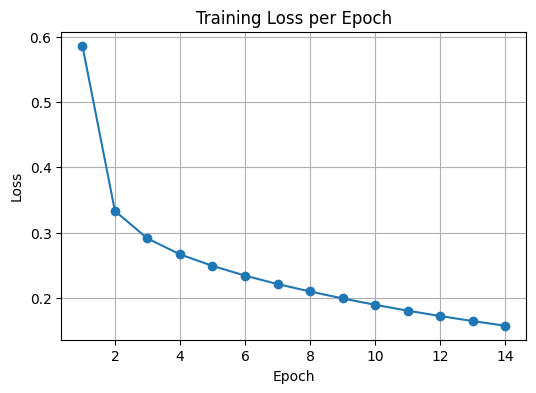

Epoch 15/15, Loss: 0.1501


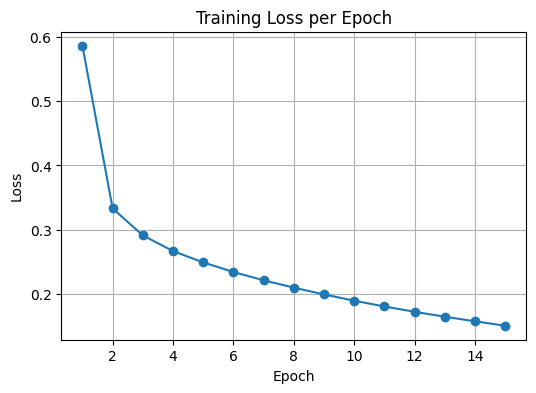

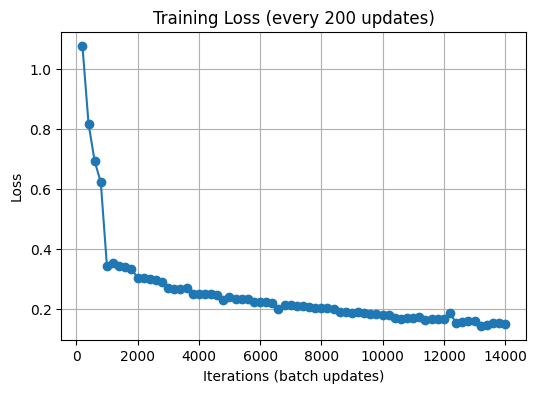

In [20]:
model = MLP_tanh()
loss_history_tanh, iter_tanh, iter_loss_tanh = train(model, train_loader)

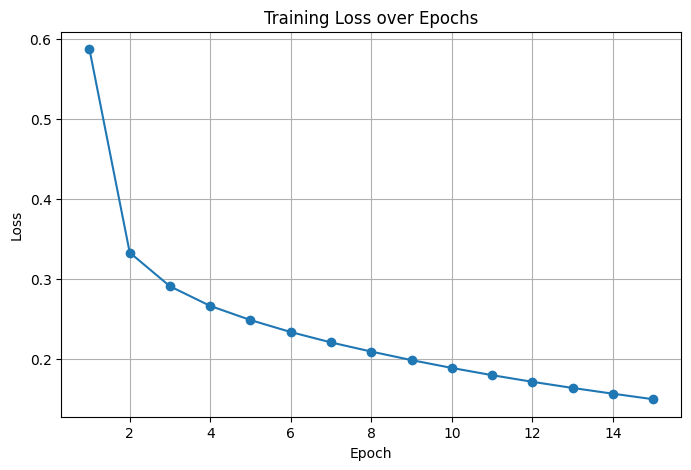

In [21]:
plot_training_curves(loss_history_tanh)

In [22]:
# Prepare test set in numpy format
X_test_np = mnist_testset.data.numpy().reshape(-1, 28*28) / 255.0
y_test_np = mnist_testset.targets.numpy()

print("---- Test Set Evaluation ----")
evaluate(model, X_test_np, y_test_np)

---- Test Set Evaluation ----
Accuracy: 95.4700%
Confusion Matrix:
[[ 968    0    1    3    0    3    3    1    1    0]
 [   0 1120    3    2    0    1    3    2    4    0]
 [   6    1  988    5    4    1    9    6   11    1]
 [   0    0   12  972    0    7    0    9    9    1]
 [   1    0    9    0  931    0    6    3    5   27]
 [   8    2    0   24    2  827   12    2   11    4]
 [   9    3    6    2    3    8  923    1    3    0]
 [   2    6   20    6    2    2    0  969    2   19]
 [   3    3    8   20    6    9    7    9  909    0]
 [   9    6    2   13   18    4    1   12    4  940]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.94      0.96      0.95      1032
           3       0.93      0.96      0.95      1010
           4       0.96      0.95      0.96       982
           5       0.96      0.93      0.94       892

np.float64(0.9547)

# **Results for MLP using Tan Hyperbolic activation function**

* Classfication accuracy over test data  = **95.47%**
* Training loss after 15 epochs = **0.1501**

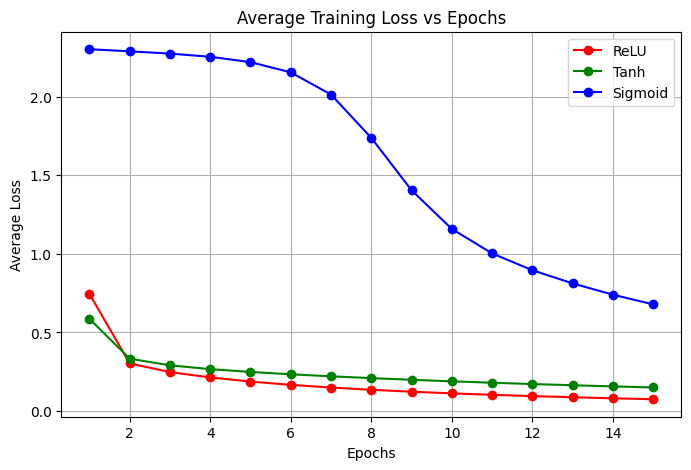

In [23]:
epochs = range(1, len(loss_history) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, loss_history_ReLu, marker='o', label="ReLU", color='r')
plt.plot(epochs, loss_history_tanh, marker='o', label="Tanh", color='g')
plt.plot(epochs, loss_history, marker='o', label="Sigmoid", color='b')

plt.title("Average Training Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.grid(True)
plt.show()

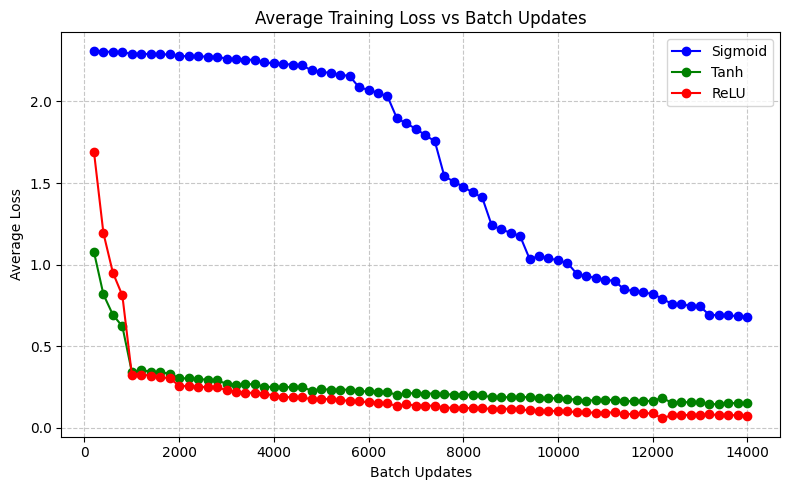

In [26]:
plt.figure(figsize=(8,5))

# Plot each activation using its own iteration indices
plt.plot(iter_tanh, iter_loss, marker='o', color='b', label="Sigmoid")
plt.plot(iter_tanh, iter_loss_tanh, marker='o', color='g', label="Tanh")
plt.plot(iter_ReLu, iter_loss_ReLu, marker='o', color='r', label="ReLU")

plt.title("Average Training Loss vs Batch Updates")
plt.xlabel("Batch Updates")
plt.ylabel("Average Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



# **Comparison for the different activation functions**

* Test accuracy for sigmoid activation function = 82.30%
* Test accuracy for ReLU activation function = 97.12%
* Test accuracy for Tan Hyperbolic activation function = 95.47%

# Conclusions:-
* The Tanh and ReLU activation functions perform almost identical.
* The Sigmoid activation function struggles to deliver good training and testing processes.
* The ReLU activation function performes relatively better.

# **Analyzing the MLP algorithm for different learning rates**

* **Learning rate = 0.1**




Epoch 1/15, Loss: 1.9364


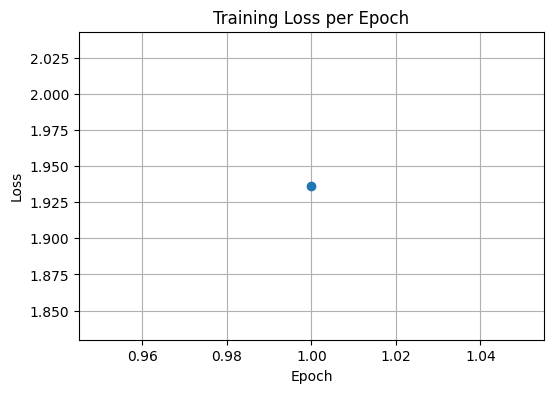

Epoch 2/15, Loss: 0.7062


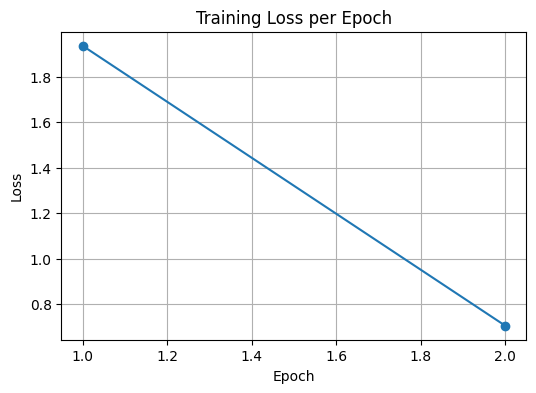

Epoch 3/15, Loss: 0.4492


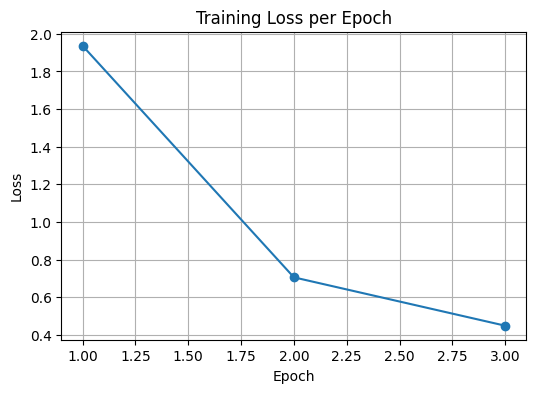

Epoch 4/15, Loss: 0.3712


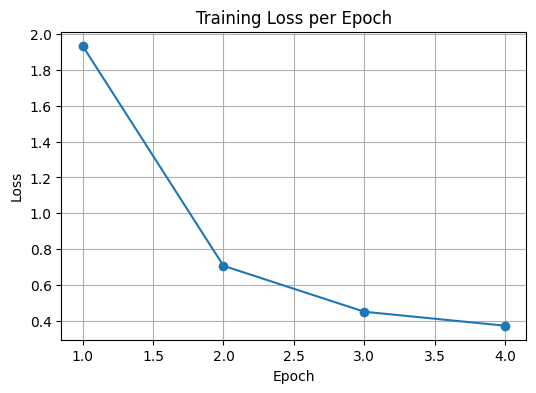

Epoch 5/15, Loss: 0.3349


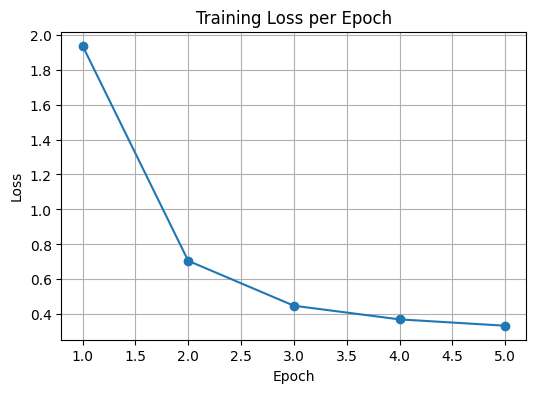

Epoch 6/15, Loss: 0.3120


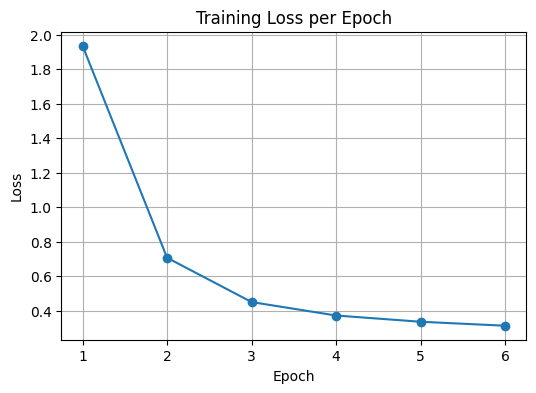

Epoch 7/15, Loss: 0.2933


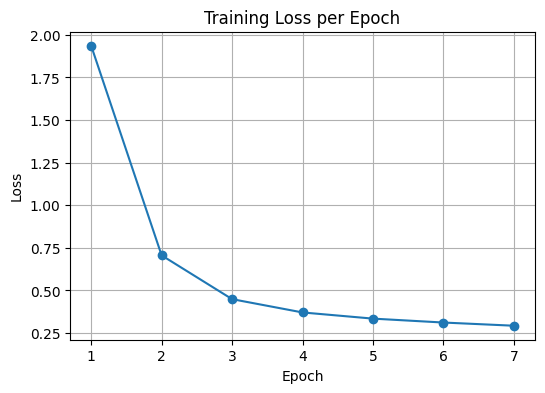

Epoch 8/15, Loss: 0.2757


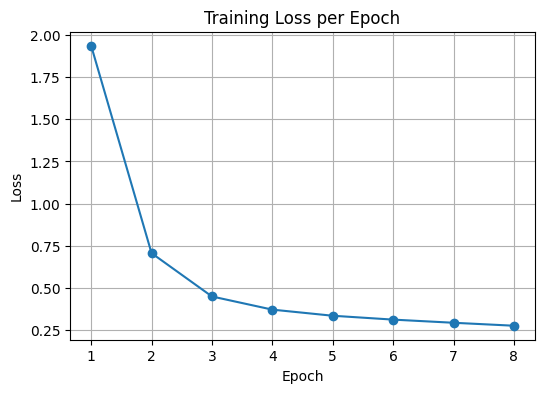

Epoch 9/15, Loss: 0.2606


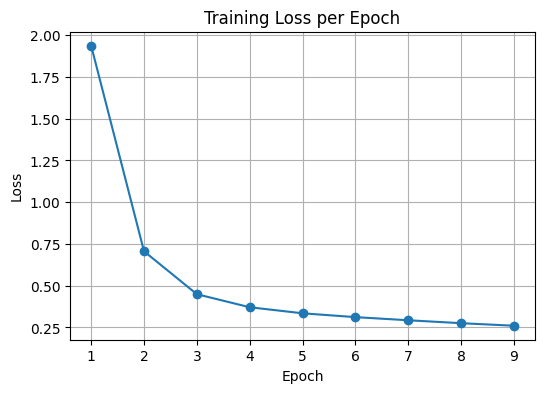

Epoch 10/15, Loss: 0.2473


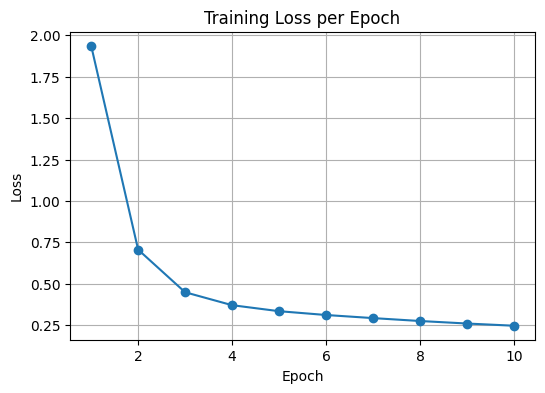

Epoch 11/15, Loss: 0.2347


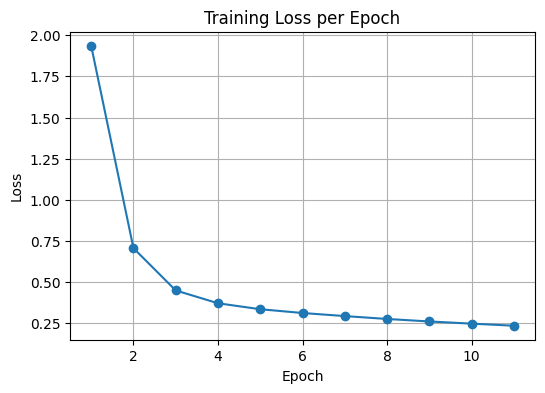

Epoch 12/15, Loss: 0.2229


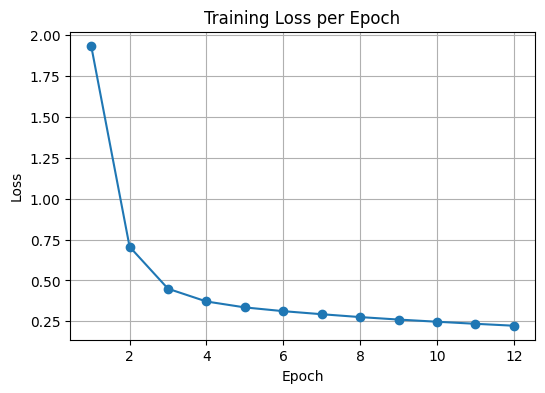

Epoch 13/15, Loss: 0.2119


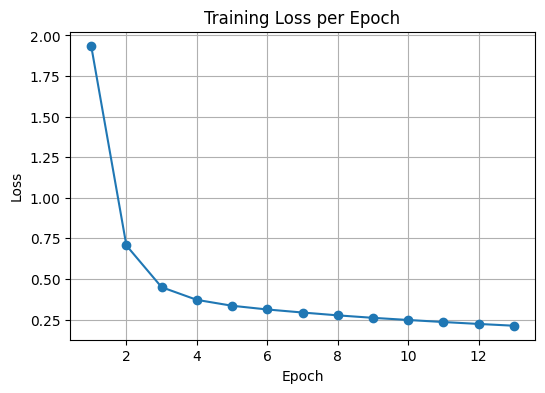

Epoch 14/15, Loss: 0.2014


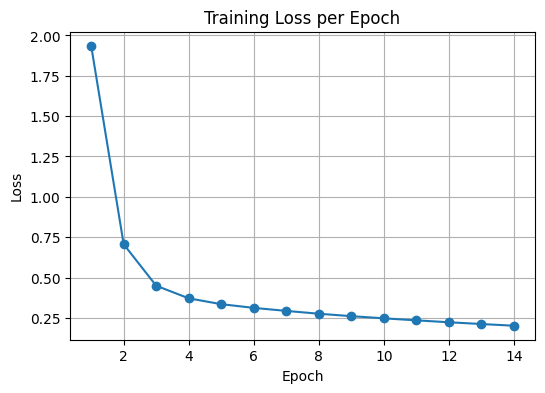

Epoch 15/15, Loss: 0.1915


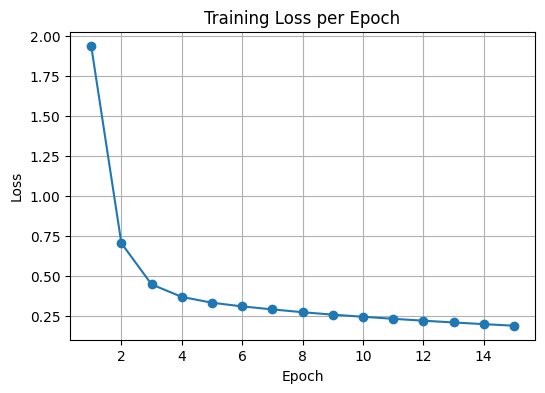

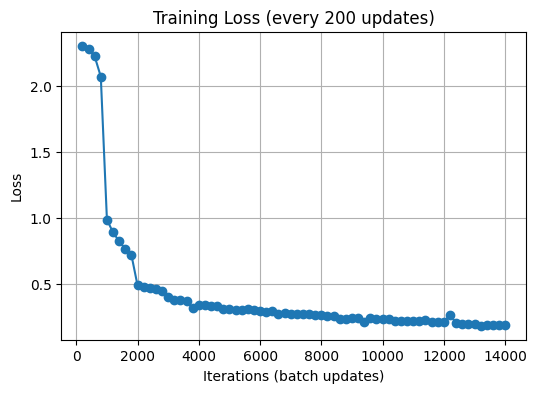

In [27]:
model_1 = MLP()
loss_history_sigmoid_1, iter_sigmoid_1, iter_loss_sigmoid_1 = train(model_1, train_loader, 15, 0.1)

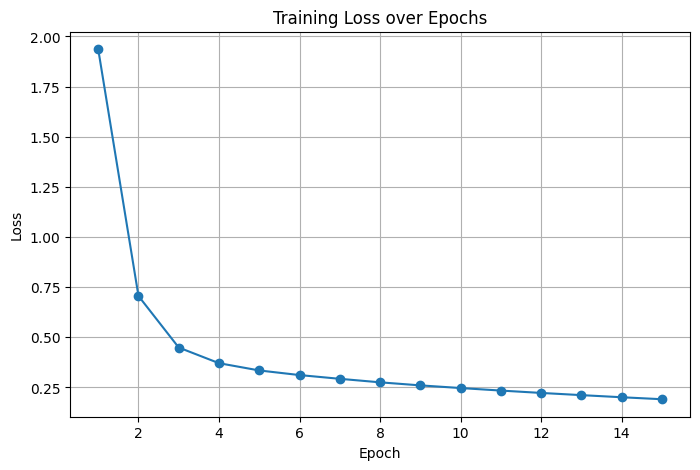

In [28]:
plot_training_curves(loss_history_sigmoid_1)

In [29]:
X_test_np = mnist_testset.data.numpy().reshape(-1, 28*28) / 255.0
y_test_np = mnist_testset.targets.numpy()

print("Test Set Evaluation for Learning rate = 0.1")
evaluate(model_1, X_test_np, y_test_np)

Test Set Evaluation for Learning rate = 0.1
Accuracy: 94.2500%
Confusion Matrix:
[[ 963    0    1    1    0    8    5    2    0    0]
 [   0 1113    2    2    0    2    4    2   10    0]
 [  12    2  965    6    4    4   13   11   13    2]
 [   0    0   15  953    0   25    1    8    6    2]
 [   3    2    4    0  906    2   12    2    4   47]
 [   7    1    0   16    2  837   11    1   13    4]
 [  12    3    2    1    7   23  907    0    3    0]
 [   3    8   18    8    1    2    0  972    0   16]
 [   6    4    4   20    5   49    8   10  865    3]
 [  10    5    1    8   15    8    1   13    4  944]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.94      0.94      1032
           3       0.94      0.94      0.94      1010
           4       0.96      0.92      0.94       982
           5       0.87      0.94      

np.float64(0.9425)

* **Learning rate = 0.001**



Epoch 1/15, Loss: 2.3388


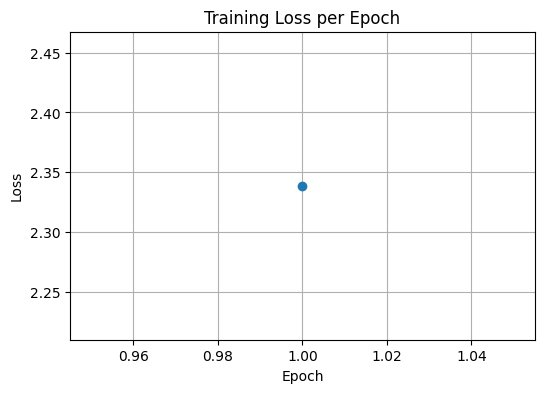

Epoch 2/15, Loss: 2.3000


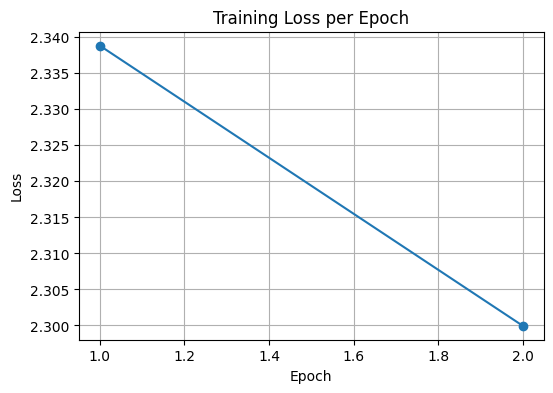

Epoch 3/15, Loss: 2.2987


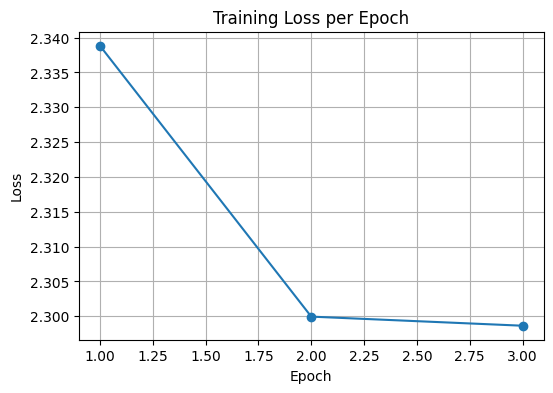

Epoch 4/15, Loss: 2.2975


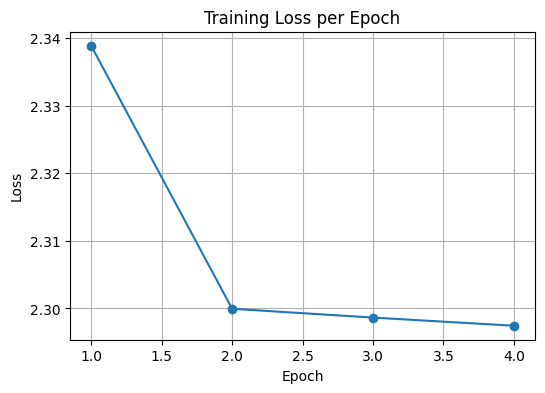

Epoch 5/15, Loss: 2.2963


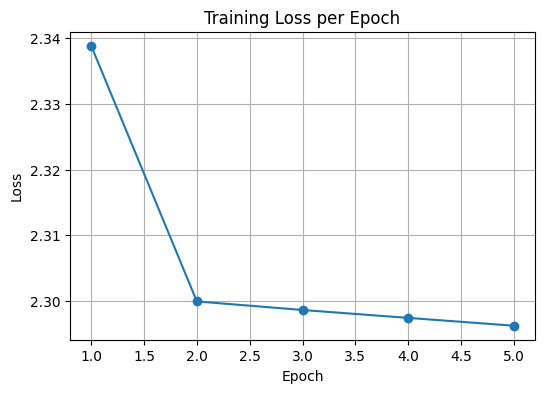

Epoch 6/15, Loss: 2.2950


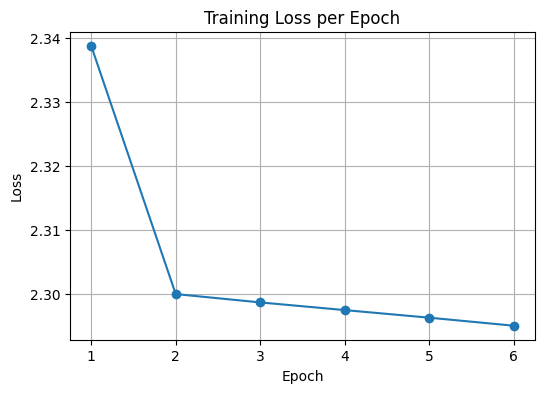

Epoch 7/15, Loss: 2.2938


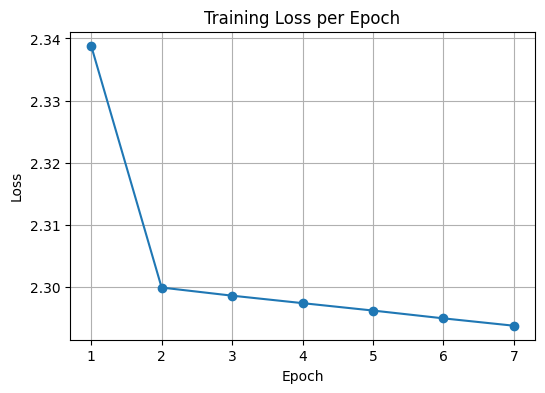

Epoch 8/15, Loss: 2.2925


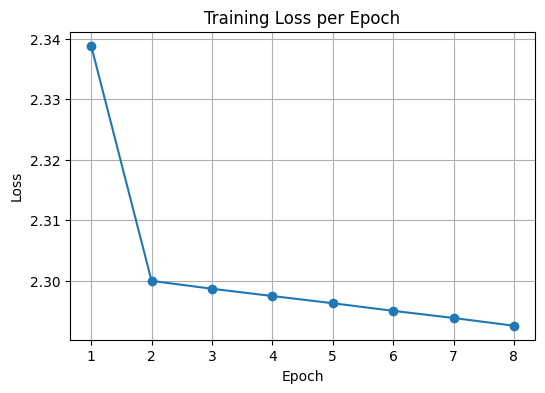

Epoch 9/15, Loss: 2.2913


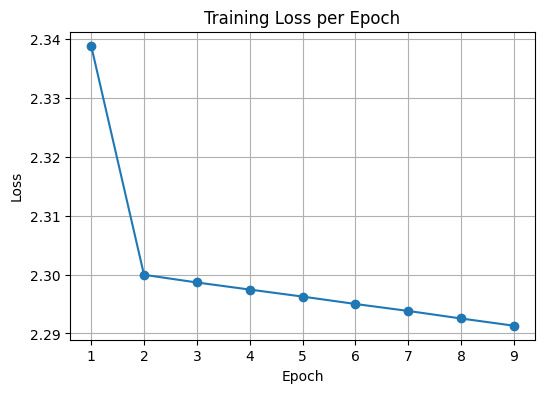

Epoch 10/15, Loss: 2.2901


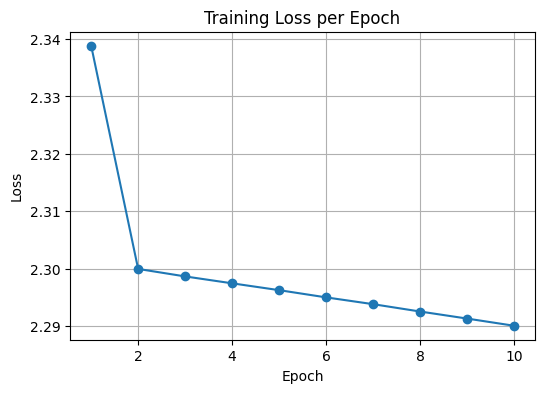

Epoch 11/15, Loss: 2.2888


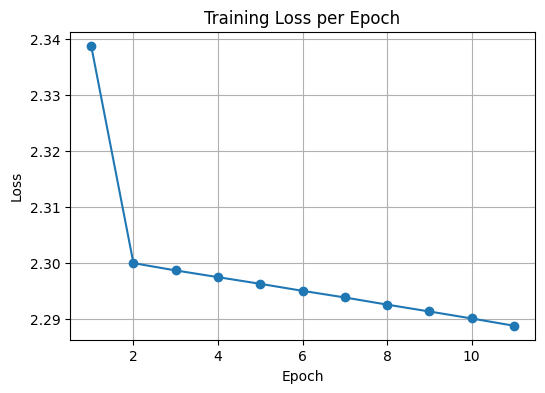

Epoch 12/15, Loss: 2.2874


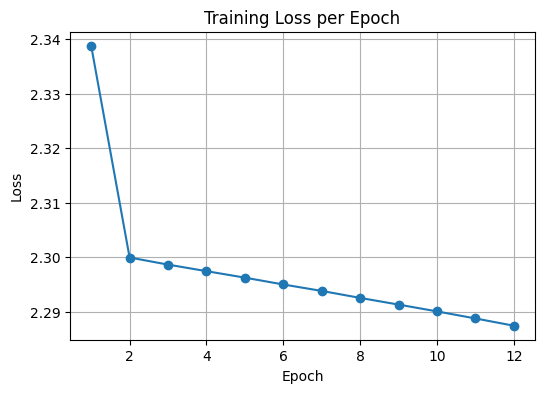

Epoch 13/15, Loss: 2.2861


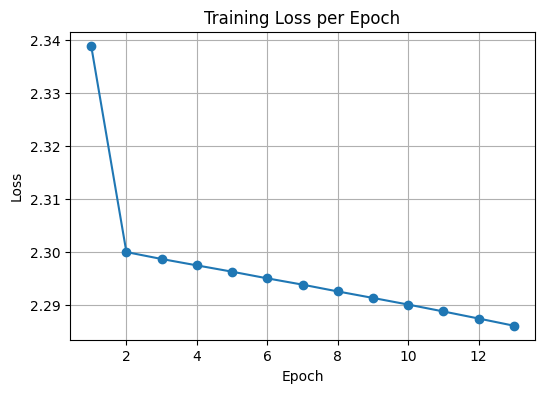

Epoch 14/15, Loss: 2.2847


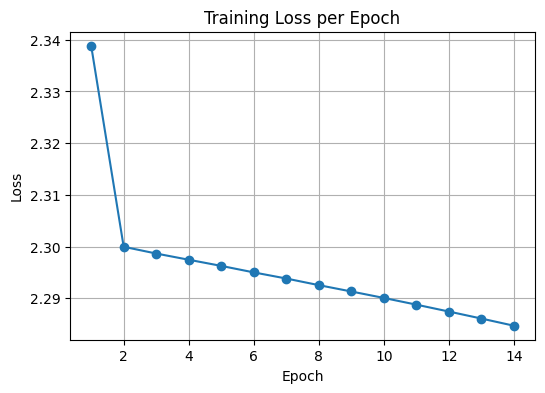

Epoch 15/15, Loss: 2.2833


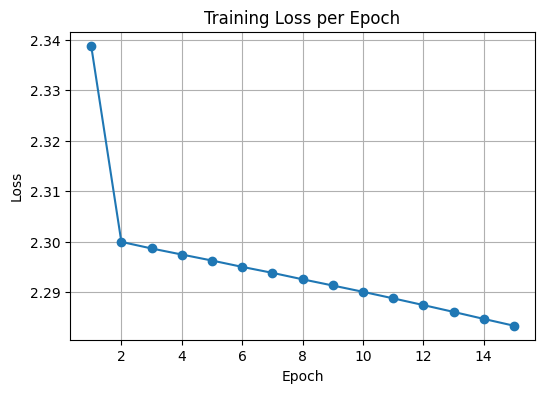

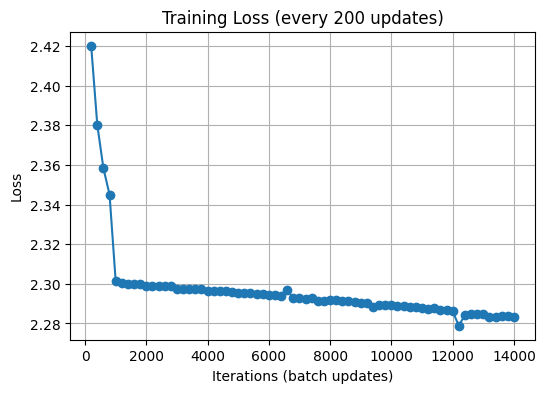

In [30]:
model_2 = MLP()
loss_history_sigmoid_2, iter_sigmoid_2, iter_loss_sigmoid_2 = train(model_2, train_loader, 15, 0.001)

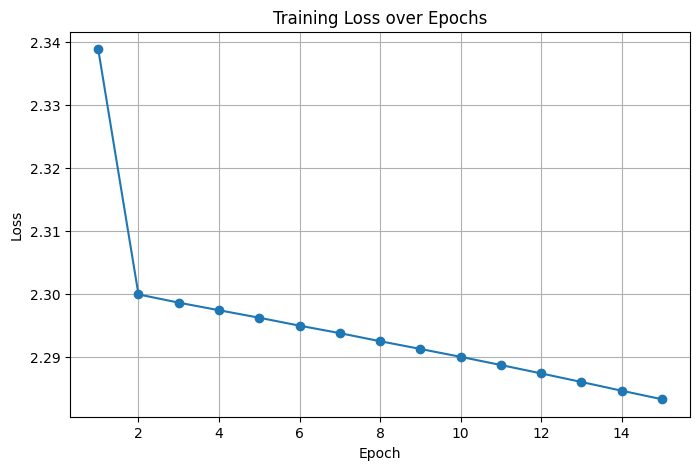

In [34]:
plot_training_curves(loss_history_sigmoid_2)

In [35]:
X_test_np = mnist_testset.data.numpy().reshape(-1, 28*28) / 255.0
y_test_np = mnist_testset.targets.numpy()

print("Test Set Evaluation for Learning rate = 0.001")
evaluate(model_2, X_test_np, y_test_np)

Test Set Evaluation for Learning rate = 0.001
Accuracy: 11.5600%
Confusion Matrix:
[[  19  961    0    0    0    0    0    0    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0 1032    0    0    0    0    0    0    0    0]
 [   0 1008    0    2    0    0    0    0    0    0]
 [   0  982    0    0    0    0    0    0    0    0]
 [   0  892    0    0    0    0    0    0    0    0]
 [   0  958    0    0    0    0    0    0    0    0]
 [   0 1028    0    0    0    0    0    0    0    0]
 [   0  974    0    0    0    0    0    0    0    0]
 [   0 1009    0    0    0    0    0    0    0    0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.02      0.04       980
           1       0.11      1.00      0.20      1135
           2       0.00      0.00      0.00      1032
           3       1.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


np.float64(0.1156)

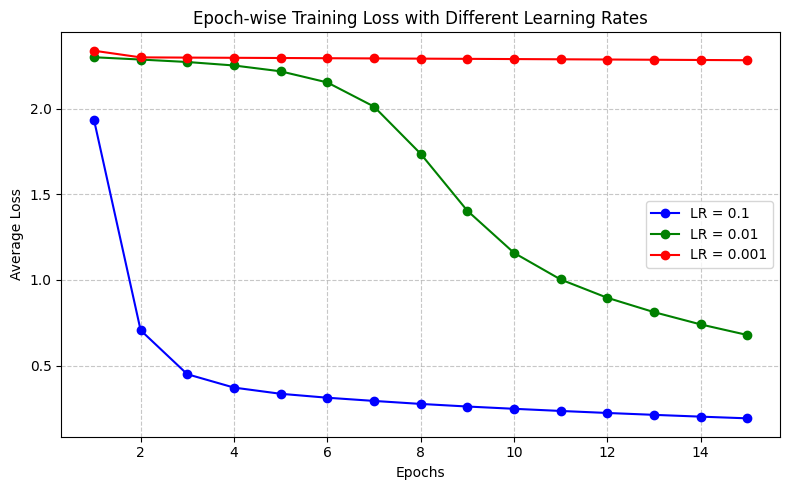

In [41]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(loss_history_sigmoid_1)+1), loss_history_sigmoid_1, marker='o', color='b', label="LR = 0.1")
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o', color='g', label="LR = 0.01")
plt.plot(range(1, len(loss_history_sigmoid_2)+1), loss_history_sigmoid_2, marker='o', color='r', label="LR = 0.001")
plt.title("Epoch-wise Training Loss with Different Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


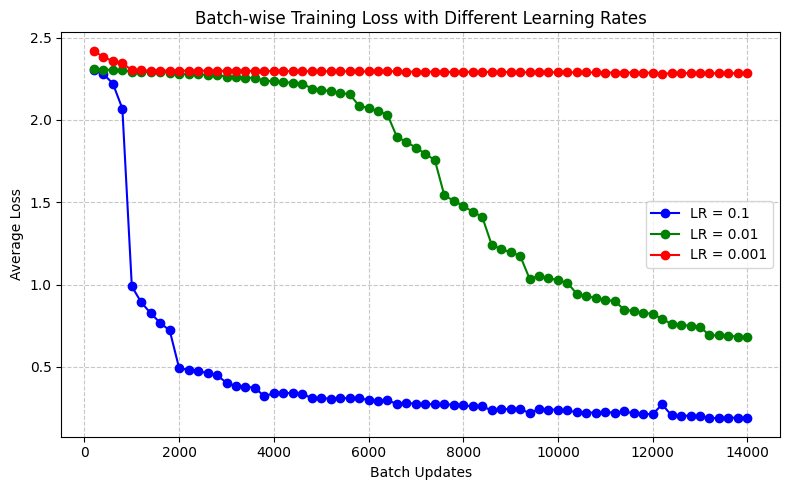

In [42]:
plt.figure(figsize=(8,5))
plt.plot(iter_sigmoid_1, iter_loss_sigmoid_1, marker='o', color='b', label="LR = 0.1")
plt.plot(iter_tanh, iter_loss, marker='o', color='g', label="LR = 0.01")
plt.plot(iter_sigmoid_2, iter_loss_sigmoid_2, marker='o', color='r', label="LR = 0.001")
plt.title("Batch-wise Training Loss with Different Learning Rates")
plt.xlabel("Batch Updates")
plt.ylabel("Average Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# **Observations and Conclusions for different learning rates for the baseline model using Sigmoid Activation**

* Test Accuracy with learning rate = 0.001 -> **11.56%**
* Test Accuracy with learning rate = 0.01 -> **82.30%** (Baseline model)
* Test Accuracy with learning rate = 0.1 -> **94.25%**

**Higher Learning rate leads to better test accuracy and lesser loss in training. Increasing the learning rate helped in improving the baseline model quite drastically**

# **Analyzing the MLP baseline model for different num of epochs using Sigmoid activation function**

**Number of Epochs = 10**

Epoch 1/10, Loss: 2.3019


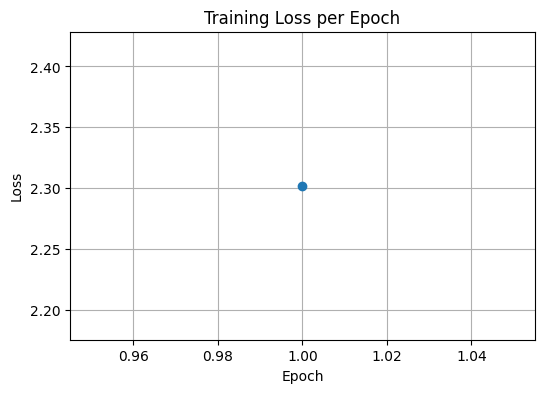

Epoch 2/10, Loss: 2.2834


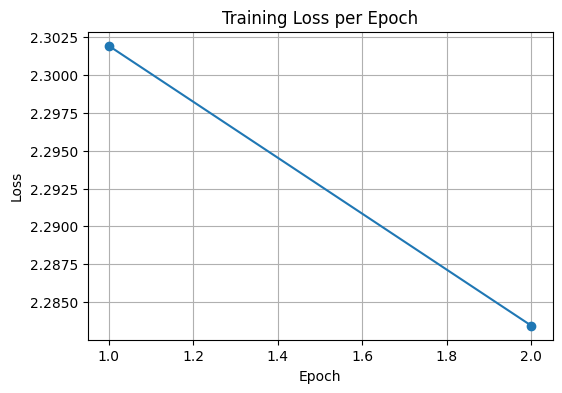

Epoch 3/10, Loss: 2.2667


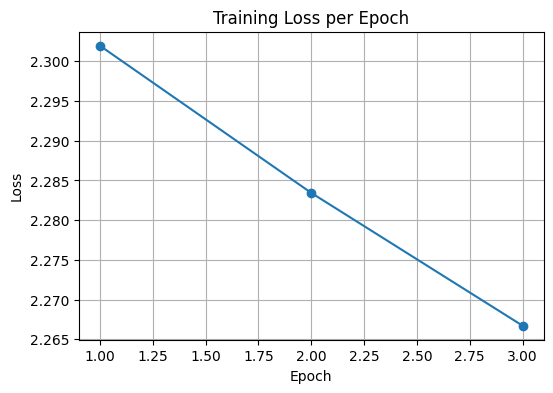

Epoch 4/10, Loss: 2.2415


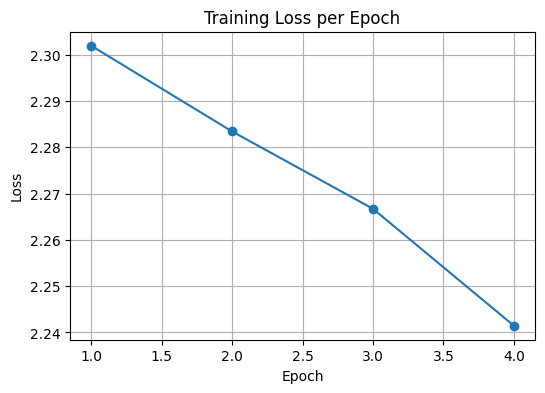

Epoch 5/10, Loss: 2.1958


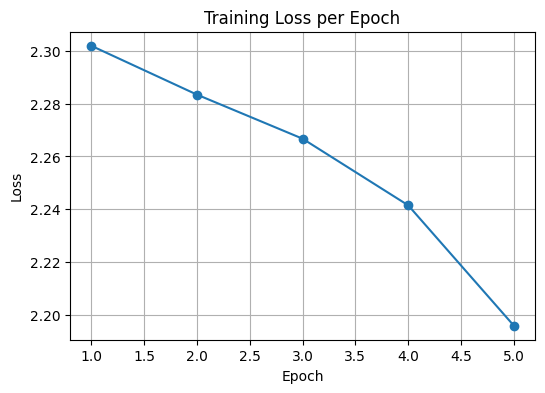

Epoch 6/10, Loss: 2.1000


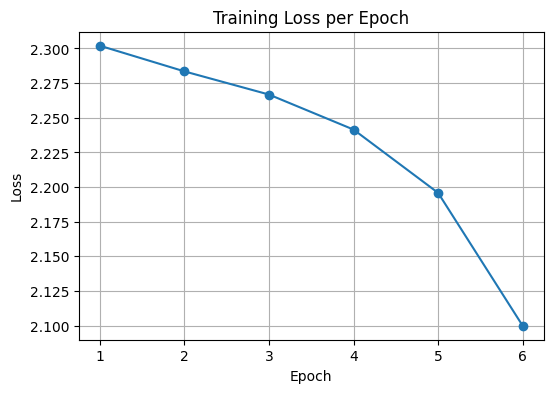

Epoch 7/10, Loss: 1.8891


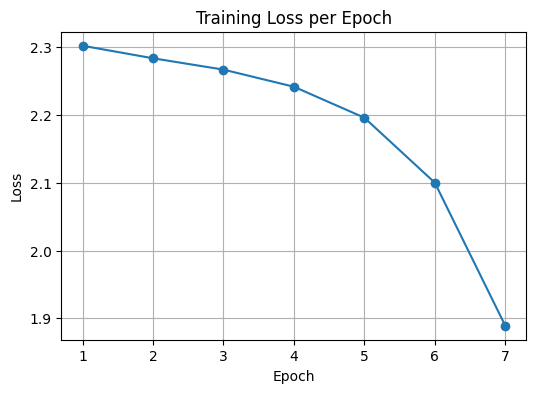

Epoch 8/10, Loss: 1.5635


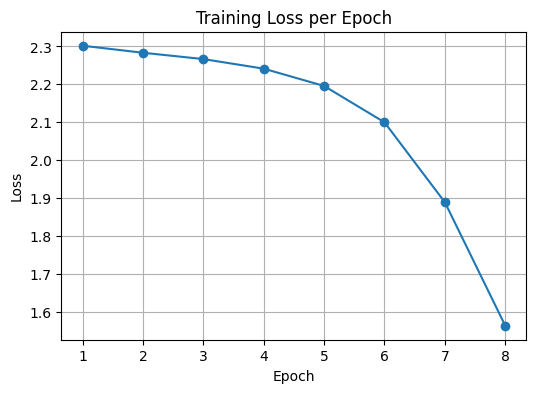

Epoch 9/10, Loss: 1.2815


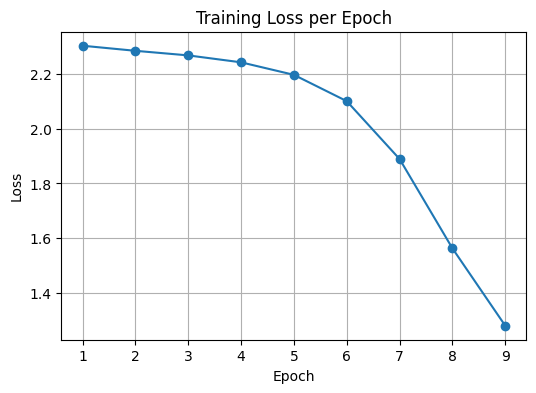

Epoch 10/10, Loss: 1.0842


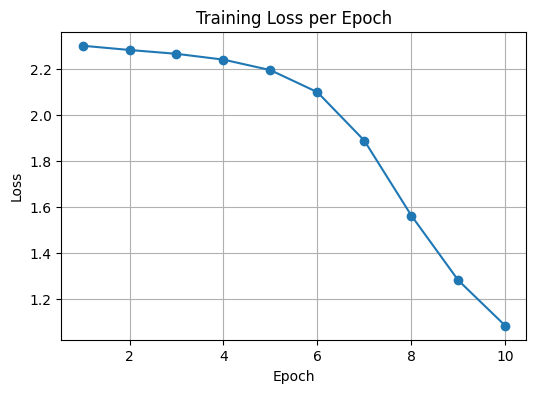

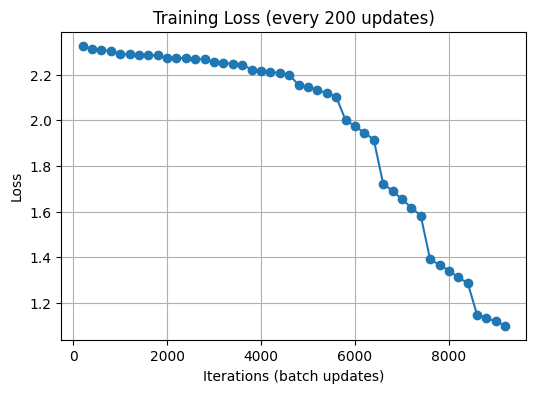

In [33]:
model_3 = MLP()
loss_history_sigmoid_3, iter_sigmoid_3, iter_loss_sigmoid_3 = train(model_3, train_loader, 10, 0.01)

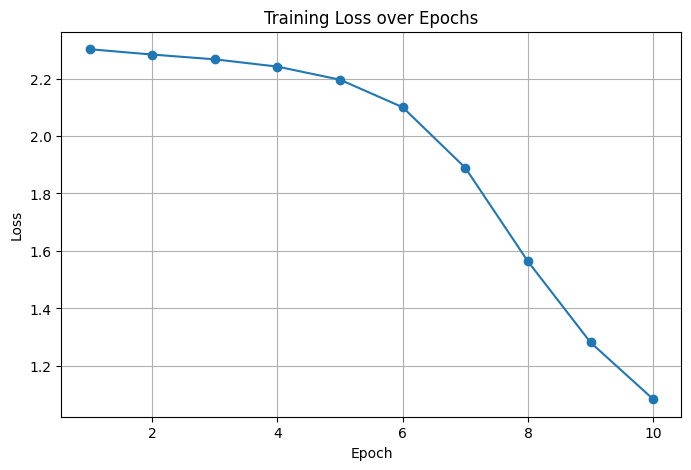

In [36]:
plot_training_curves(loss_history_sigmoid_3)

In [37]:
X_test_np = mnist_testset.data.numpy().reshape(-1, 28*28) / 255.0
y_test_np = mnist_testset.targets.numpy()

print("Test Set Evaluation for 10 epochs")
evaluate(model_3, X_test_np, y_test_np)

Test Set Evaluation for 10 epochs
Accuracy: 69.7600%
Confusion Matrix:
[[ 942    0    1    4    1   21    8    1    2    0]
 [   0 1121    4    5    0    0    1    0    3    1]
 [  34   42  705   67   30   10  114    7   20    3]
 [   8   32   53  829    3   41    1   17   18    8]
 [   1   28    2    0  607    0   50   20    1  273]
 [  57   16   35  269   18  353   34   56   36   18]
 [  39    7   61    0   18    8  815    0   10    0]
 [   4   71    8    2   14    9    1  852    8   59]
 [  40  127  114  292   15   42   21   24  262   37]
 [  16   26    1   11  185    9    8  263    0  490]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       980
           1       0.76      0.99      0.86      1135
           2       0.72      0.68      0.70      1032
           3       0.56      0.82      0.67      1010
           4       0.68      0.62      0.65       982
           5       0.72      0.40      0.51      

np.float64(0.6976)

**Number of Epochs  = 20**

Epoch 1/20, Loss: 2.2998


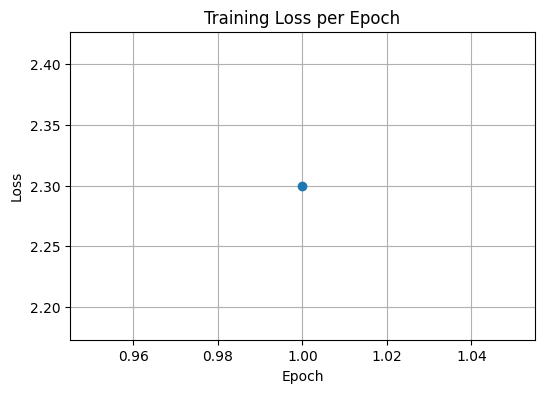

Epoch 2/20, Loss: 2.2865


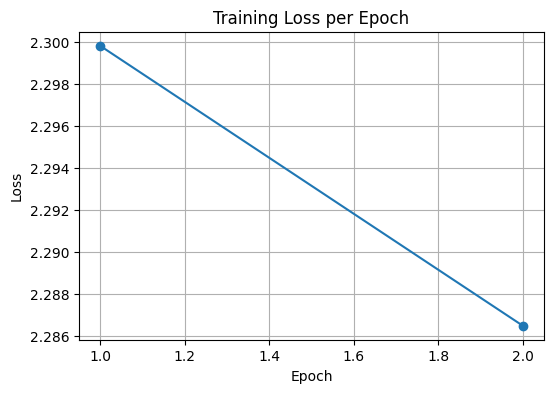

Epoch 3/20, Loss: 2.2719


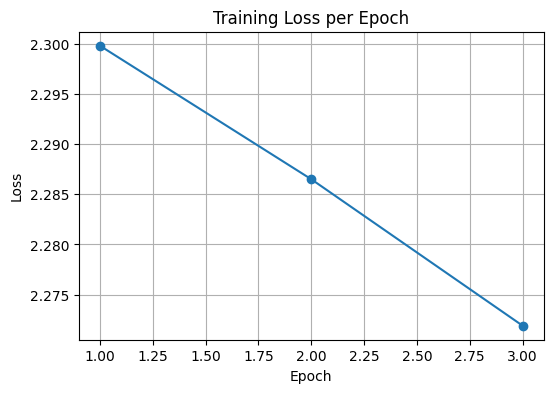

Epoch 4/20, Loss: 2.2496


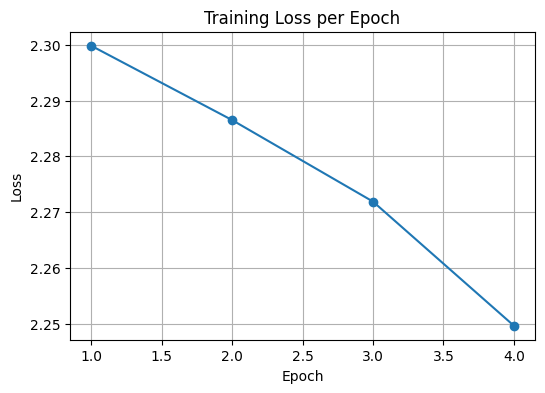

Epoch 5/20, Loss: 2.2099


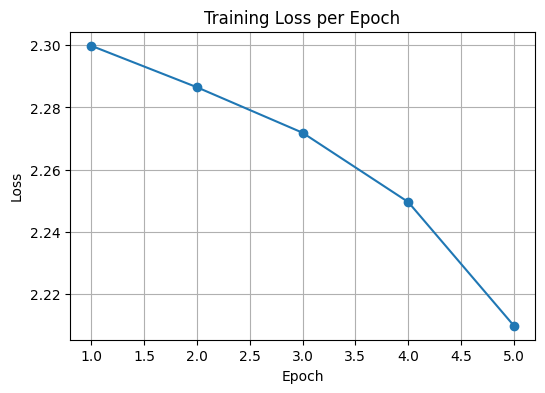

Epoch 6/20, Loss: 2.1279


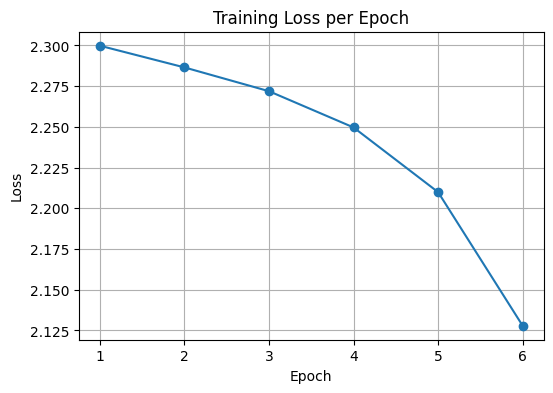

Epoch 7/20, Loss: 1.9578


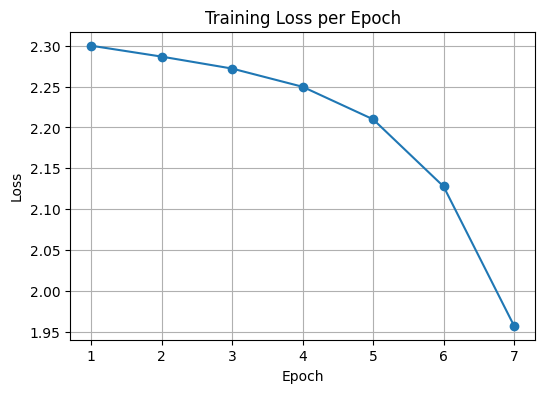

Epoch 8/20, Loss: 1.7073


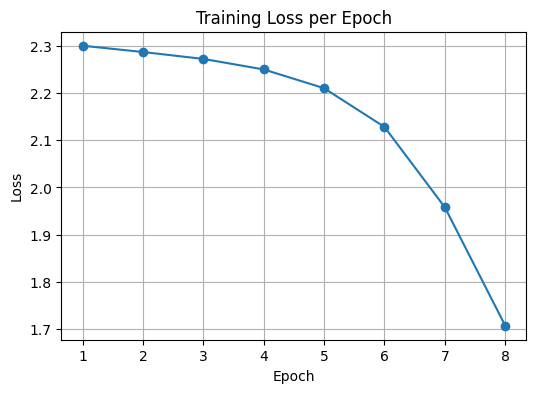

Epoch 9/20, Loss: 1.4472


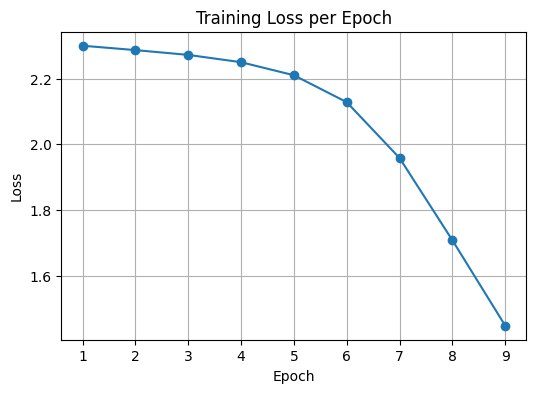

Epoch 10/20, Loss: 1.2305


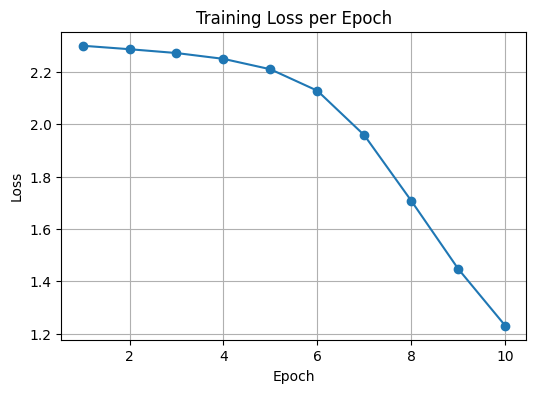

Epoch 11/20, Loss: 1.0625


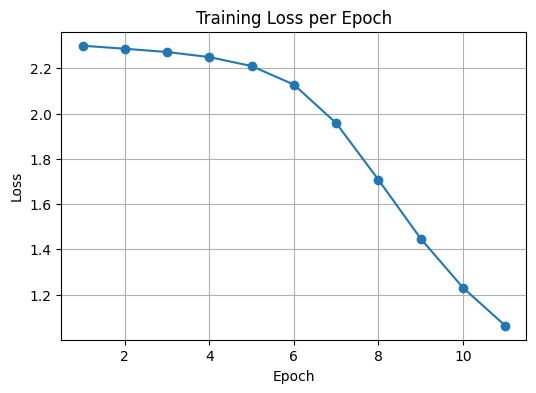

Epoch 12/20, Loss: 0.9382


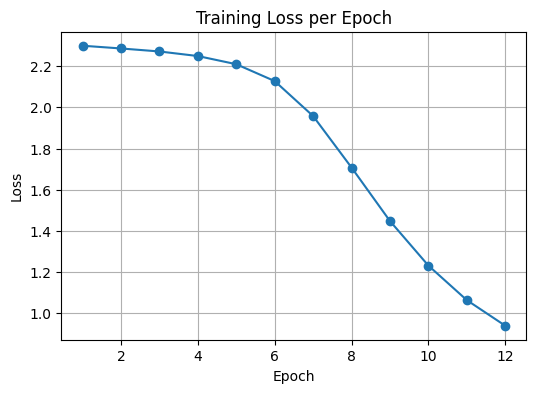

Epoch 13/20, Loss: 0.8494


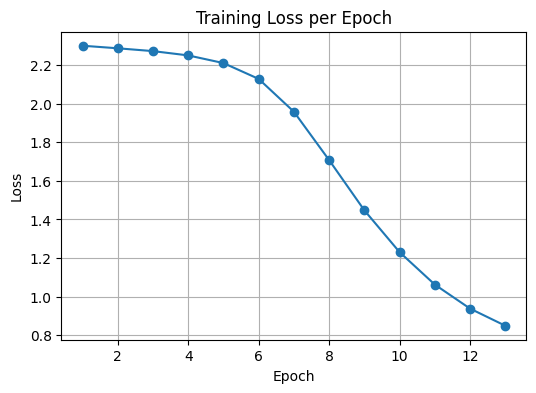

Epoch 14/20, Loss: 0.7807


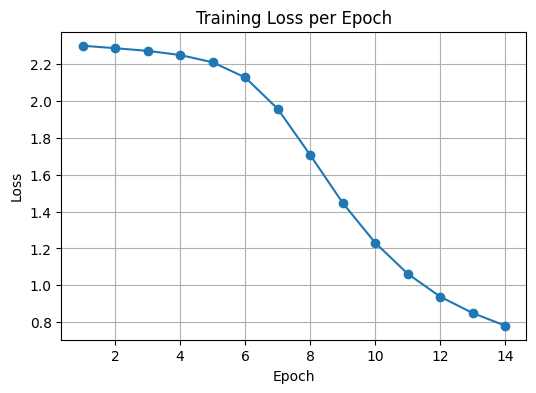

Epoch 15/20, Loss: 0.7219


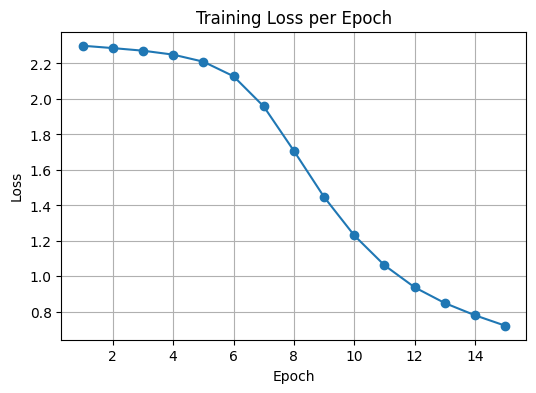

Epoch 16/20, Loss: 0.6701


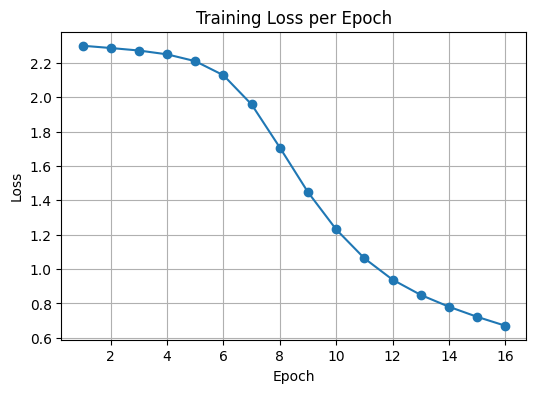

Epoch 17/20, Loss: 0.6244


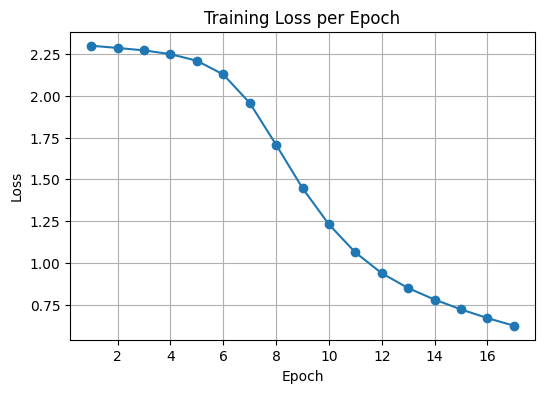

Epoch 18/20, Loss: 0.5850


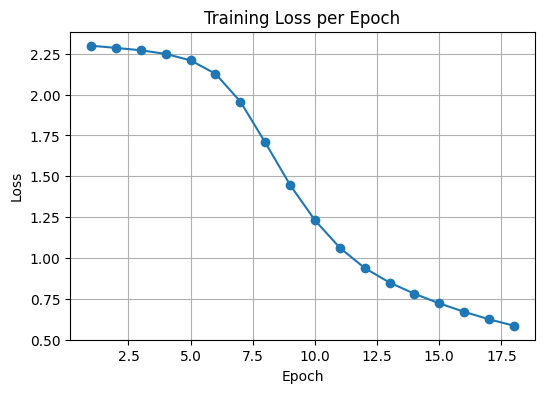

Epoch 19/20, Loss: 0.5523


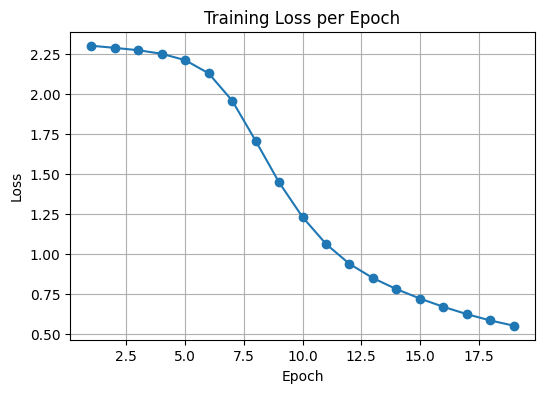

Epoch 20/20, Loss: 0.5247


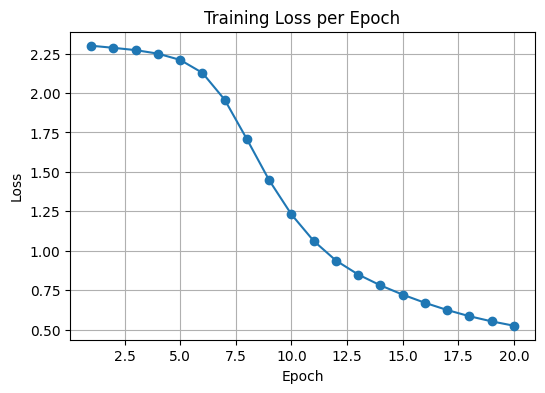

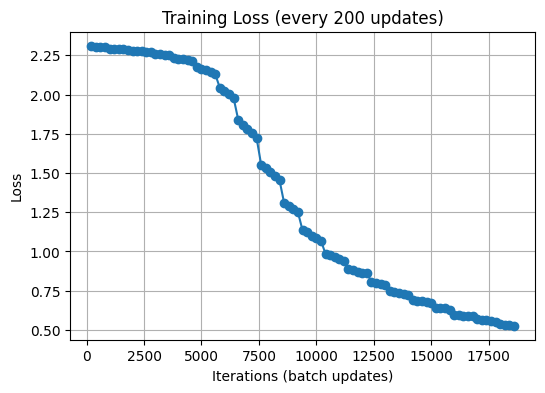

In [38]:
model_4 = MLP()
loss_history_sigmoid_4, iter_sigmoid_4, iter_loss_sigmoid_4 = train(model_4, train_loader, 20, 0.01)

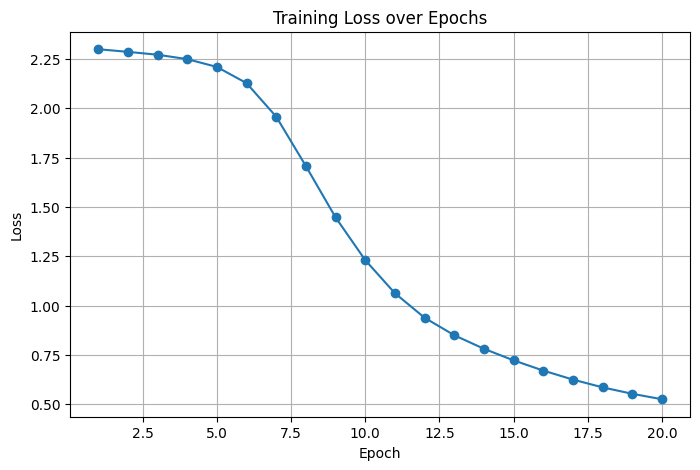

In [39]:
plot_training_curves(loss_history_sigmoid_4)

In [40]:
X_test_np = mnist_testset.data.numpy().reshape(-1, 28*28) / 255.0
y_test_np = mnist_testset.targets.numpy()

print("Test Set Evaluation for 20 epochs")
evaluate(model_4, X_test_np, y_test_np)

Test Set Evaluation for 20 epochs
Accuracy: 85.3900%
Confusion Matrix:
[[ 951    0    2    3    0   13   10    1    0    0]
 [   0 1112    1    6    0    2    3    1    9    1]
 [  14   11  866   58   24    2   23   10   19    5]
 [   3    7   46  842    0   48    1   18   39    6]
 [   1    8    5    0  804    0   23    0    8  133]
 [  22    3   12   90   11  656   29    8   46   15]
 [  24    4   12    1   15   21  878    0    3    0]
 [   6   32   27    7    1    1    0  888    5   61]
 [   9   21   21   45   27   51   17    9  743   31]
 [  13    8    7    5   99   15    0   51   12  799]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       980
           1       0.92      0.98      0.95      1135
           2       0.87      0.84      0.85      1032
           3       0.80      0.83      0.81      1010
           4       0.82      0.82      0.82       982
           5       0.81      0.74      0.77      

np.float64(0.8539)

**Number of Epochs = 25**

Epoch 1/25, Loss: 2.2970


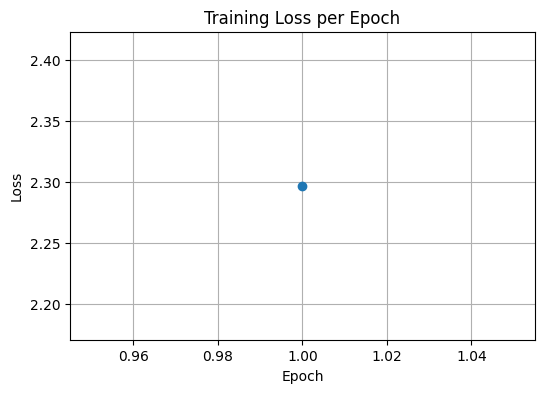

Epoch 2/25, Loss: 2.2814


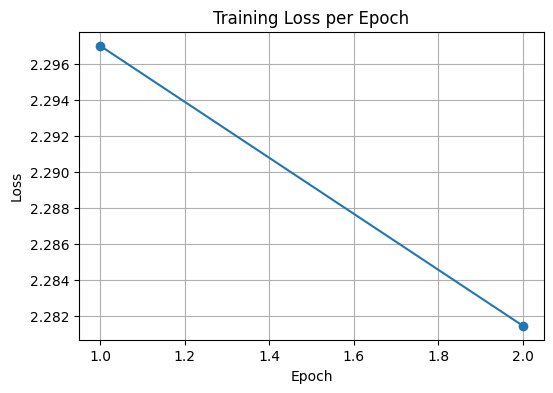

Epoch 3/25, Loss: 2.2629


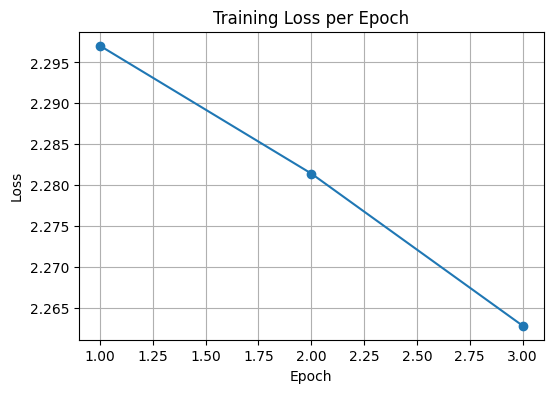

Epoch 4/25, Loss: 2.2339


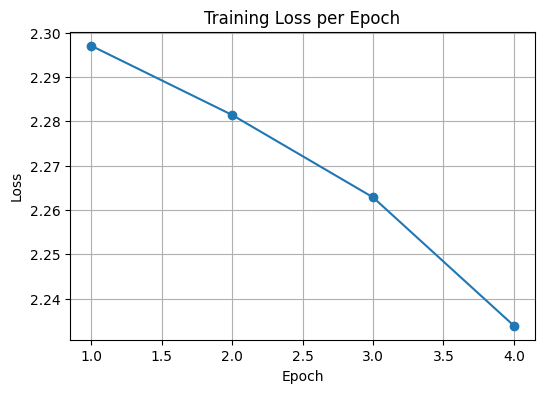

Epoch 5/25, Loss: 2.1803


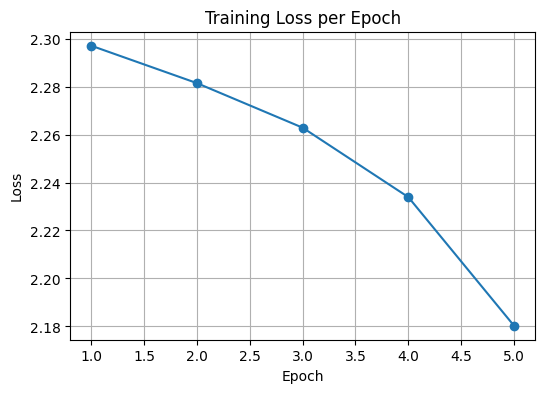

Epoch 6/25, Loss: 2.0673


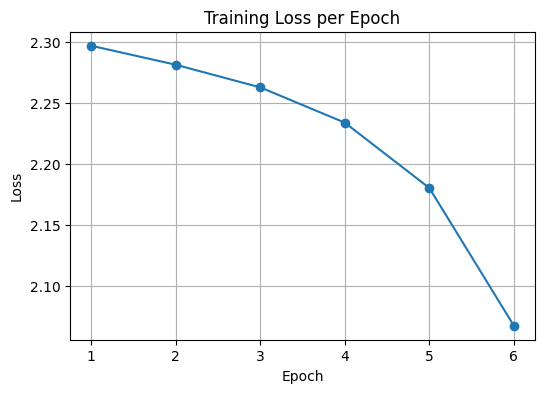

Epoch 7/25, Loss: 1.8402


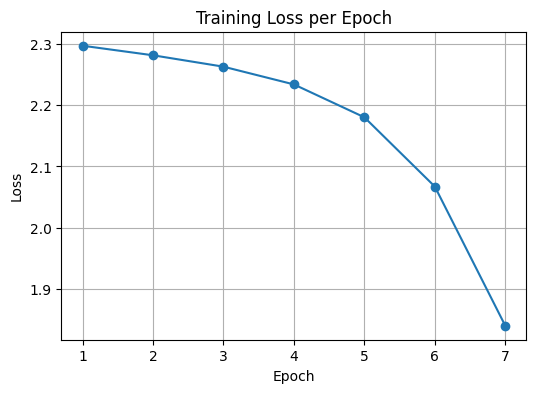

Epoch 8/25, Loss: 1.5197


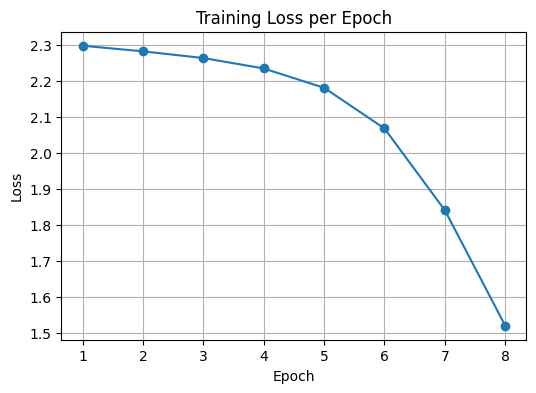

Epoch 9/25, Loss: 1.2224


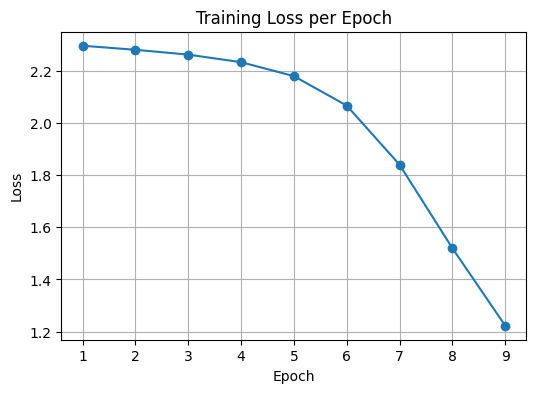

Epoch 10/25, Loss: 1.0162


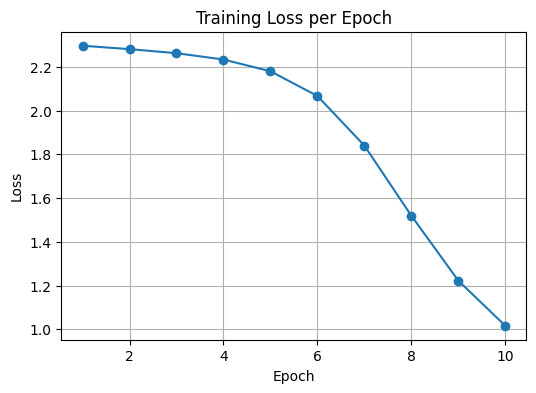

Epoch 11/25, Loss: 0.8891


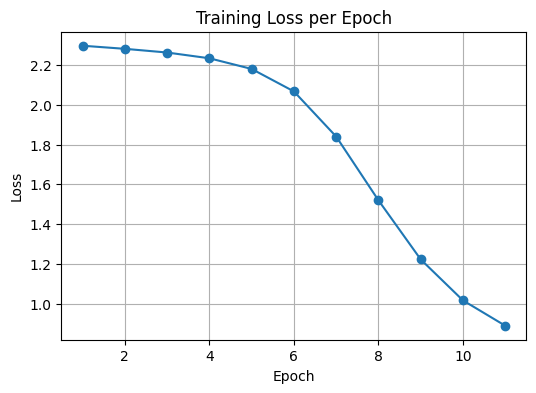

Epoch 12/25, Loss: 0.8073


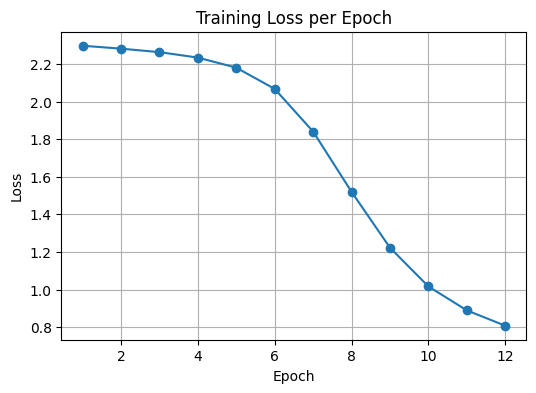

Epoch 13/25, Loss: 0.7487


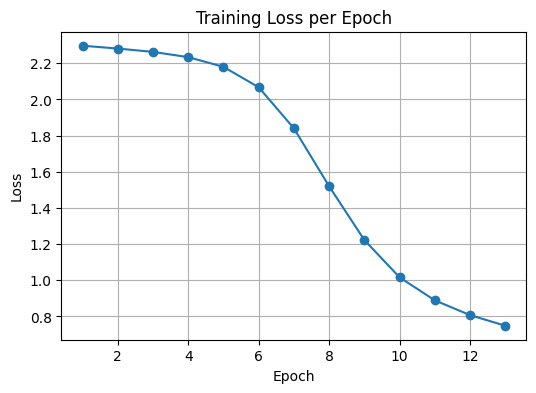

Epoch 14/25, Loss: 0.7022


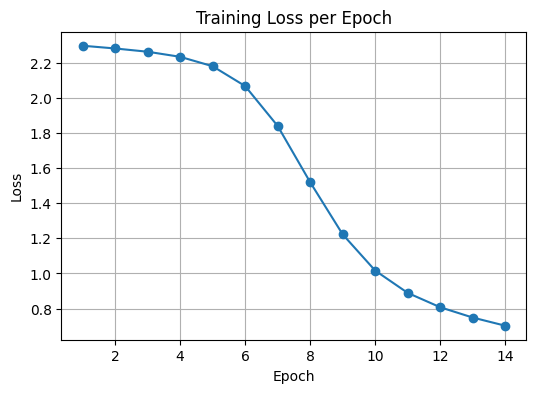

Epoch 15/25, Loss: 0.6632


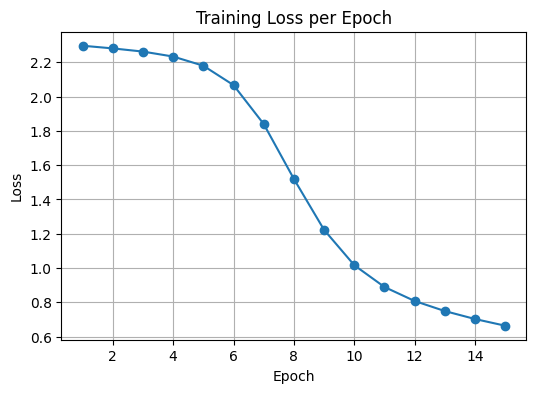

Epoch 16/25, Loss: 0.6288


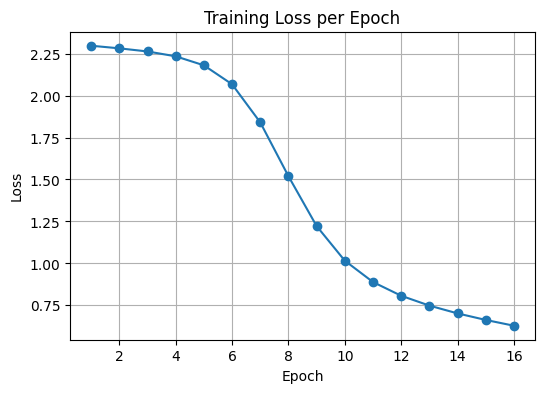

Epoch 17/25, Loss: 0.5977


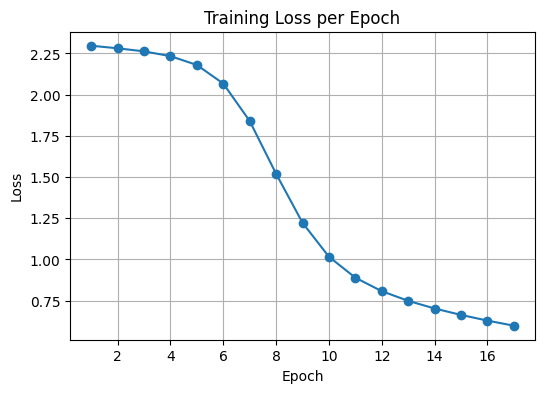

Epoch 18/25, Loss: 0.5694


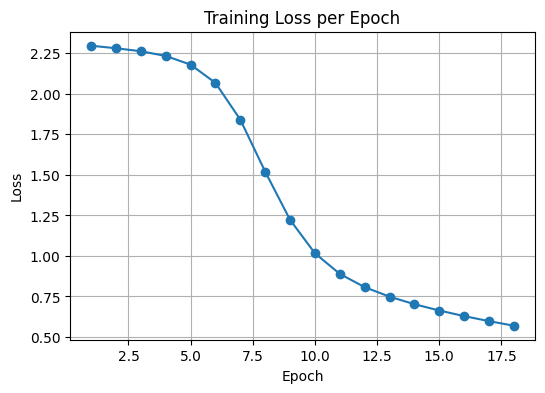

Epoch 19/25, Loss: 0.5437


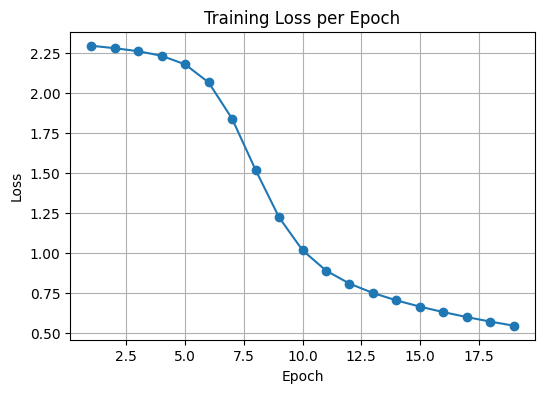

Epoch 20/25, Loss: 0.5201


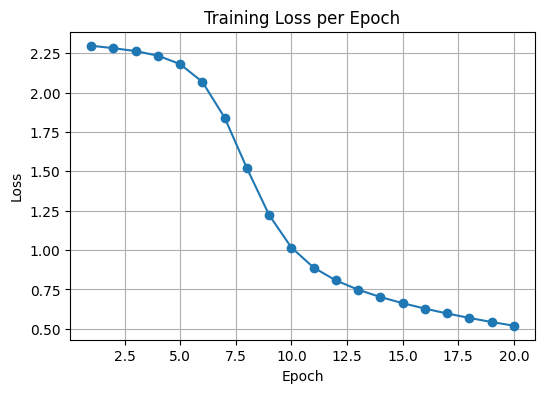

Epoch 21/25, Loss: 0.4989


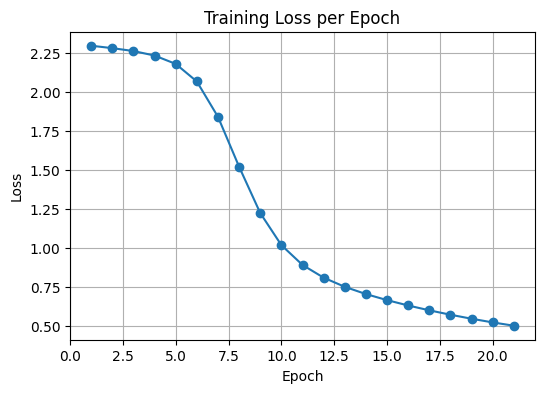

Epoch 22/25, Loss: 0.4801


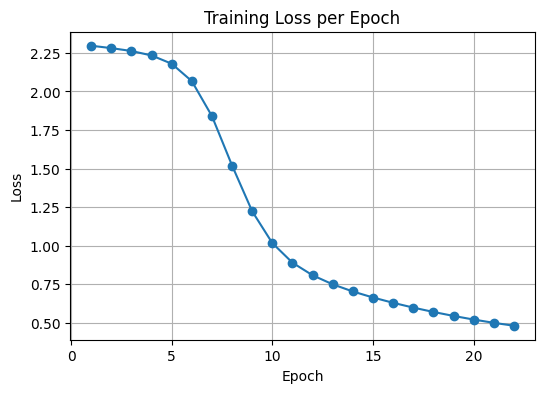

Epoch 23/25, Loss: 0.4632


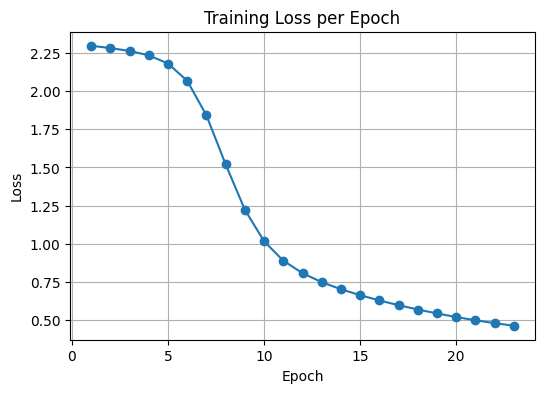

Epoch 24/25, Loss: 0.4486


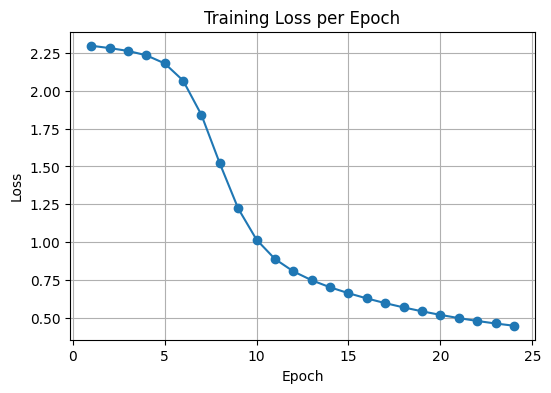

Epoch 25/25, Loss: 0.4352


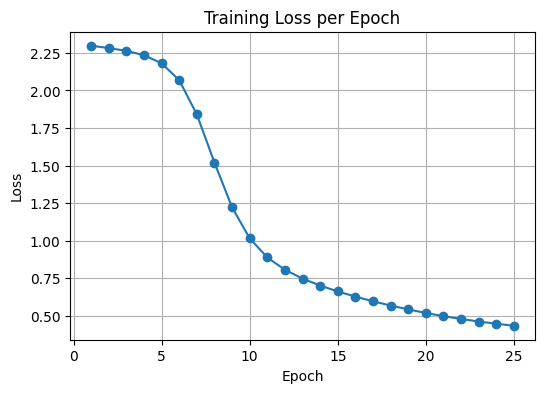

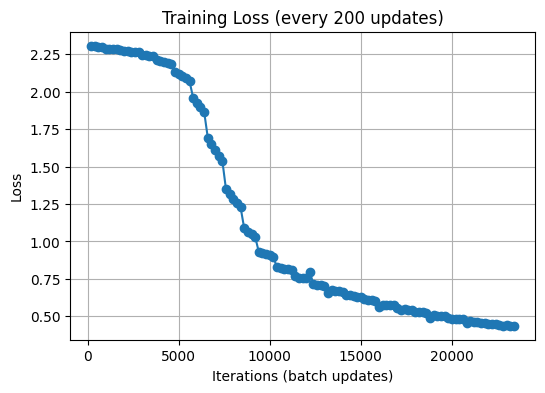

In [43]:
model_5 = MLP()
loss_history_sigmoid_5, iter_sigmoid_5, iter_loss_sigmoid_5 = train(model_5, train_loader, 25, 0.01)

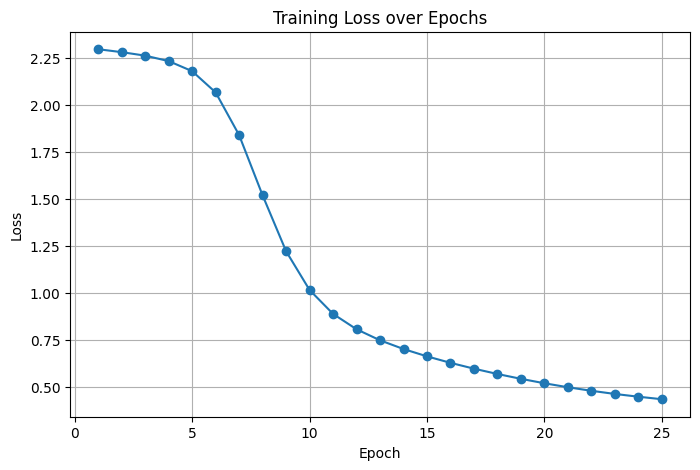

In [44]:
plot_training_curves(loss_history_sigmoid_5)

In [47]:
X_test_np = mnist_testset.data.numpy().reshape(-1, 28*28) / 255.0
y_test_np = mnist_testset.targets.numpy()

print("Test Set Evaluation for 25 epochs")
evaluate(model_5, X_test_np, y_test_np)

Test Set Evaluation for 25 epochs
Accuracy: 87.7500%
Confusion Matrix:
[[ 948    0    2    3    0   18    6    2    1    0]
 [   0 1094    1    6    1    3    3    1   26    0]
 [  16   13  861   41   21    4   21    9   38    8]
 [   4    1   35  849    1   58    0   24   32    6]
 [   1    2    6    0  885    1   12    1    9   65]
 [  14    3    8   49   11  723   26   14   36    8]
 [  25    2   12    0   24   22  869    0    4    0]
 [   7   16   20   11    5    1    0  907    5   56]
 [   5    5   12   28   16   46   19    6  818   19]
 [  10    3    3    6   93   16    1   42   14  821]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       980
           1       0.96      0.96      0.96      1135
           2       0.90      0.83      0.86      1032
           3       0.85      0.84      0.85      1010
           4       0.84      0.90      0.87       982
           5       0.81      0.81      0.81      

np.float64(0.8775)

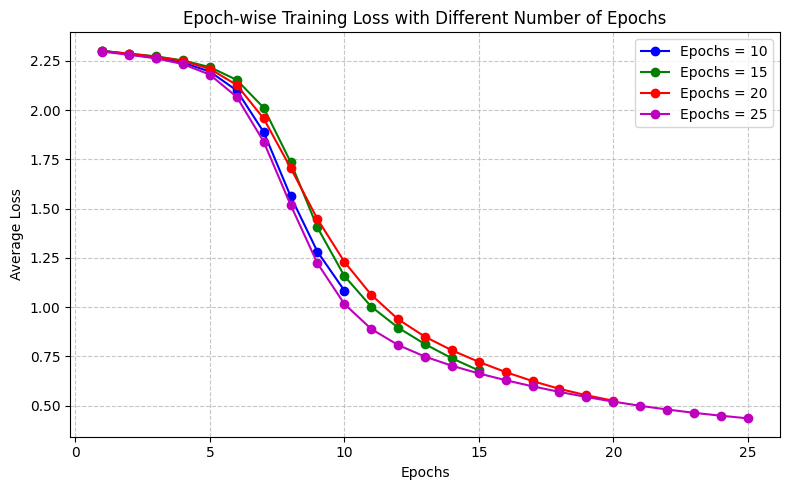

In [48]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(loss_history_sigmoid_3)+1), loss_history_sigmoid_3, marker='o', color='b', label="Epochs = 10")
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o', color='g', label="Epochs = 15")
plt.plot(range(1, len(loss_history_sigmoid_4)+1), loss_history_sigmoid_4, marker='o', color='r', label="Epochs = 20")
plt.plot(range(1, len(loss_history_sigmoid_5)+1), loss_history_sigmoid_5, marker='o', color='m', label="Epochs = 25")
plt.title("Epoch-wise Training Loss with Different Number of Epochs")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

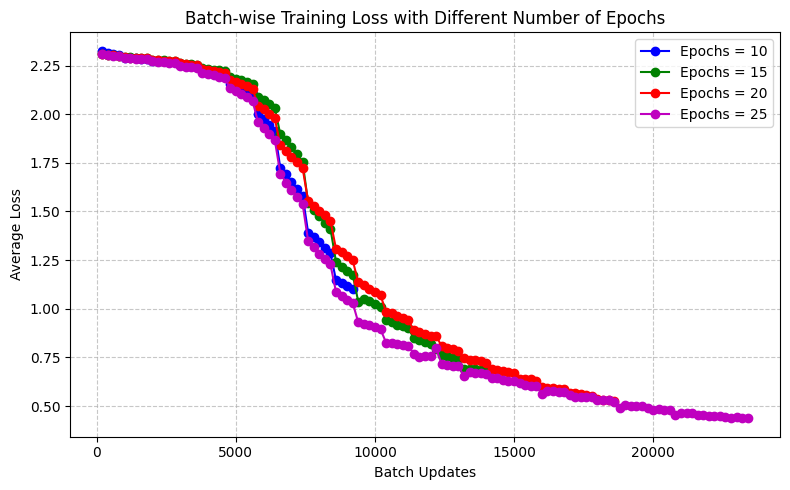

In [49]:
plt.figure(figsize=(8,5))
plt.plot(iter_sigmoid_3, iter_loss_sigmoid_3, marker='o', color='b', label="Epochs = 10")
plt.plot(iter_tanh, iter_loss, marker='o', color='g', label="Epochs = 15")
plt.plot(iter_sigmoid_4, iter_loss_sigmoid_4, marker='o', color='r', label="Epochs = 20")
plt.plot(iter_sigmoid_5, iter_loss_sigmoid_5, marker='o', color='m', label="Epochs = 25")
plt.title("Batch-wise Training Loss with Different Number of Epochs")
plt.xlabel("Batch Updates")
plt.ylabel("Average Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# **Observation and Conclusions based on variation in number of epochs**

* Test accuracy for 10 epochs = **69.76%**
* Test accuracy for 15 epochs = **82.30%**
* Test accuracy for 20 epochs = **85.39%**
* Test accuracy for 25 epochs = **87.75%**

**Increasing the number of epochs gives more time for the network to learn and hence postively helps in improving the accuracy in testing phase.**


**The overall training loss per epoch is roughly the same and independent of number of epochs**, that is the training at the nth epoch is roughly same in each case of having different number of epochs for the overall training